In [1]:
#.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
library(scibet)
library(Seurat)
library(scater)
library(scran)
library(dplyr)
library(Matrix)
library(cowplot)
library(ggplot2)
library(harmony)
rm(list = ls())
gc()
setwd('/home/data/t060324/jobs/aimin/')

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians

used     (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells  7981828 426.3 14808651   790.9 10206884 545.2
Vcells 13716140 104.7 21468864   163.8 17824054 136.0

In [114]:
mergeData_B <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_B.RDS')

In [21]:
mergeData_T <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_T.RDS')

In [2]:
mergeData_TAM <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_TAM.RDS')

In [117]:
mergeData_CAF_m <- readRDS(file='./output/1.sangleCell_pre/OV_mergeData_CAF_m.RDS')

In [22]:
table(mergeData_T$cellType)


    CD8+Te         Tn       Treg         NK       Th17   ISG+CD8T    CD8+Tem 
      8038       8921       6080       5776       4976       4401       4177 
CD8+TpreEx    CD8+Tex  Mature NK     CD8+Tn     unknow        Tfh    CD38+NK 
      3128       2463       3042       1724          0       1270       1010 

In [35]:
mergeData_T$cellType <- as.character(mergeData_T$cellType)

In [24]:
mergeData_TAM$cellType <- as.character(mergeData_TAM$cellType)

ERROR: Error in eval(expr, envir, enclos): object 'mergeData_TAM' not found


In [5]:
table(mergeData_T$patient_id)

ERROR: Error in eval(quote(list(...)), env): object 'mergeData_T' not found


In [25]:
mergeData_T <- subset(mergeData_T,cellType !='unknow')

In [36]:
mergeData_T$cellType <- ifelse(mergeData_T$cellType=='PD1+ CD8T','CD8+Tex-like',mergeData_T$cellType)
#mergeData_T$cellType <- ifelse(mergeData_T$cellType=='CD8+TpreEx','GZMK+ CD8T',mergeData_T$cellType)
mergeData_T$cellType <- ifelse(mergeData_T$cellType=='CCL4L2+ CD8T','CD8+Tem',mergeData_T$cellType)

In [37]:
table(mergeData_T$cellType)


     CD38+NK       CD8+Te      CD8+Tem CD8+Tex-like       CD8+Tn   GZMK+ CD8T 
        1010         8038         4177         2463         1724         3128 
    ISG+CD8T    Mature NK           NK          Tfh         Th17           Tn 
        4401         3042         5776         1270         4976         8921 
        Treg 
        6080 

In [38]:
mergeData_T$cellType <- factor(mergeData_T$cellType,
                                    levels = c('Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex-like','CD8+Tn','GZMK+ CD8T','ISG+CD8T','NK','Mature NK','CD38+NK'),
                                    labels = c('Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex-like','CD8+Tn','GZMK+ CD8T','ISG+CD8T','NK','Mature NK','CD38+NK'))

In [39]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 33)

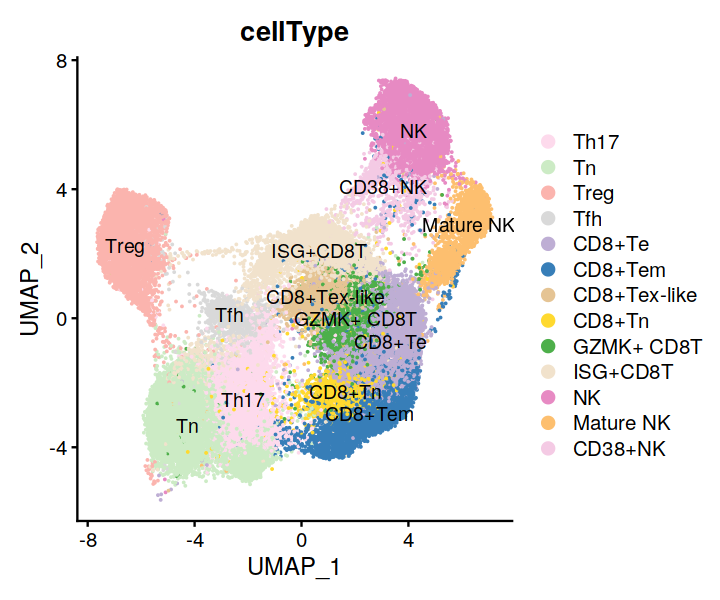

In [40]:
options(repr.plot.height = 5, repr.plot.width = 6)
dimP <- DimPlot(object = mergeData_T,reduction = 'umap',group.by = c('cellType'),cols = cellType_col[18:30], label = T)
dimP

In [41]:
pdf(file = './output/bulk/section_3/0.Tcell_DimPlot.pdf',width = 6,height = 5)
print(dimP)
dev.off()

png 
  2

In [42]:
saveRDS(mergeData_T,file = './output/1.sangleCell_pre/OV_mergeData_T.RDS')

In [32]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))


In [88]:
cellType <- as.character(mergeData_T$cellType)
names(cellType) <- colnames(mergeData_T)
cell_list <- split(colnames(mergeData_T),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)
mergeData_T_sub <- subset(mergeData_T,cells = sampleCell)

In [89]:
mergeData_T_sub <- subset(mergeData_T,cells = sampleCell)

In [90]:
expr <- t(as.matrix(mergeData_T_sub@assays$RNA@data))
expr <- as.data.frame(expr)
expr$label <- mergeData_T_sub$cellType


In [91]:
etest_gene <- SelectGene(expr = expr,k = 100)

In [92]:
etest_gene <- etest_gene[!grepl(pattern = '^RP[LS]',etest_gene)]
etest_gene <- etest_gene[!grepl(pattern = '^MT-',etest_gene)]

In [190]:
length(etest_gene)

[1] 2908

In [191]:
saveRDS(etest_gene,file = './output/1.sangleCell_pre/OV_mergeData_TcellMaker_Top3000.RDS')

In [94]:
Idents(mergeData_T) <- 'cellType'

In [7]:
Idents(mergeData_T) <- 'cellType'
TcellMarkers <- FindAllMarkers(mergeData_T,only.pos = T,logfc.threshold = 0.5,min.pct = 0.2)

Calculating cluster Th17

Calculating cluster Tn

Calculating cluster Treg

Calculating cluster Tfh

Calculating cluster CD8+Te

Calculating cluster CD8+Tem

Calculating cluster CD8+Tn

Calculating cluster CD8+TpreEx

Calculating cluster ISG+CD8T

Calculating cluster NK

Calculating cluster Mature NK

Calculating cluster CD38+NK



In [8]:
head(TcellMarkers)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
IL7R     0.000000e+00 1.1882837  0.675 0.325  0.000000e+00 Th17    IL7R   
CD40LG   0.000000e+00 0.9708659  0.251 0.055  0.000000e+00 Th17    CD40LG 
ANXA1   9.151163e-302 0.8340384  0.800 0.614 4.356411e-297 Th17    ANXA1  
S100A11 1.148813e-223 0.6364675  0.806 0.681 5.468922e-219 Th17    S100A11
GPR183  4.086068e-215 0.8244749  0.435 0.248 1.945173e-210 Th17    GPR183 
KLF6    2.626298e-191 0.6974044  0.849 0.752 1.250249e-186 Th17    KLF6

In [13]:
subset(TcellMarkers,cluster=='CD8+Te')

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
GZMH      0.000000e+00 1.3222662  0.716 0.286  0.000000e+00 CD8+Te  GZMH    
CD8A      0.000000e+00 1.2131879  0.734 0.284  0.000000e+00 CD8+Te  CD8A    
CD8B      0.000000e+00 1.0719795  0.599 0.224  0.000000e+00 CD8+Te  CD8B    
ZNF683    0.000000e+00 0.9328318  0.401 0.144  0.000000e+00 CD8+Te  ZNF683  
ITM2C     0.000000e+00 0.8990705  0.525 0.246  0.000000e+00 CD8+Te  ITM2C   
CCL5      0.000000e+00 0.8406769  0.968 0.693  0.000000e+00 CD8+Te  CCL5    
GZMA      0.000000e+00 0.7996946  0.772 0.504  0.000000e+00 CD8+Te  GZMA    
COTL1     0.000000e+00 0.7982290  0.755 0.538  0.000000e+00 CD8+Te  COTL1   
HLA-DRB1  0.000000e+00 0.7465059  0.687 0.471  0.000000e+00 CD8+Te  HLA-DRB1
GZMK      0.000000e+00 0.7405345  0.641 0.350  0.000000e+00 CD8+Te  GZMK    
ALOX5AP   0.000000e+00 0.7007212  0.667 0.473  0.000000e+00 CD8+Te  ALOX5AP 
HLA-DPA1  0.000000e+00 0.6895118  0.659 0.459  0.000000e+00 CD8+Te  HLA-DPA1
HLA-DPB1  0.000000e+00 0.6854737  0.721 0.500  0.000000e+00 CD8+Te  HLA-DPB1
HLA-DQA1  0.000000e+00 0.6806482  0.408 0.220  0.000000e+00 CD8+Te  HLA-DQA1
APOBEC3G  0.000000e+00 0.6111071  0.659 0.472  0.000000e+00 CD8+Te  APOBEC3G
SH3BGRL3  0.000000e+00 0.6013218  0.904 0.831  0.000000e+00 CD8+Te  SH3BGRL3
CD52      0.000000e+00 0.5586153  0.846 0.736  0.000000e+00 CD8+Te  CD52    
S100A6    0.000000e+00 0.5505282  0.892 0.826  0.000000e+00 CD8+Te  S100A6  
CST7      0.000000e+00 0.5075478  0.776 0.570  0.000000e+00 CD8+Te  CST7    
HLA-DRA  2.336390e-287 0.6336017  0.616 0.433 1.112239e-282 CD8+Te  HLA-DRA 
HLA-DQB1 1.348262e-281 0.6451863  0.498 0.313 6.418403e-277 CD8+Te  HLA-DQB1
HLA-DRB5 7.565345e-269 0.5723820  0.326 0.164 3.601483e-264 CD8+Te  HLA-DRB5
LGALS1   1.889462e-268 0.5992844  0.717 0.561 8.994786e-264 CD8+Te  LGALS1  
GYG1     1.101474e-256 0.5750808  0.327 0.173 5.243566e-252 CD8+Te  GYG1    
PTMS     4.856625e-245 0.5967399  0.419 0.249 2.311996e-240 CD8+Te  PTMS    
TRBC1    1.737241e-237 0.6741623  0.643 0.523 8.270138e-233 CD8+Te  TRBC1   
TRGC2    8.797826e-236 0.5399796  0.323 0.168 4.188205e-231 CD8+Te  TRGC2   
YBX3     4.466435e-233 0.5601742  0.257 0.121 2.126246e-228 CD8+Te  YBX3    
GZMM     3.903179e-211 0.5144904  0.531 0.371 1.858109e-206 CD8+Te  GZMM    
APOBEC3H 1.277336e-210 0.5009481  0.239 0.116 6.080760e-206 CD8+Te  APOBEC3H
GRAP2    9.431897e-203 0.5195751  0.297 0.164 4.490055e-198 CD8+Te  GRAP2   
C12orf75 9.770369e-202 0.5396070  0.424 0.273 4.651184e-197 CD8+Te  C12orf75
TUBA4A   8.352072e-181 0.5176394  0.591 0.444 3.976004e-176 CD8+Te  TUBA4A  
GLUL     3.904084e-171 0.5626620  0.288 0.163 1.858539e-166 CD8+Te  GLUL    
MT1E      2.013692e-65 0.6993463  0.263 0.187  9.586179e-61 CD8+Te  MT1E    
MT1X      1.073095e-36 0.5563936  0.306 0.249  5.108468e-32 CD8+Te  MT1X

In [96]:
top10 <- TcellMarkers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Warning message:
“All elements of `...` must be named.
Did you want `data = -label`?”
Warning message:
“Use of `sub_expr$gene` is discouraged. Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged. Use `cell_type` instead.”


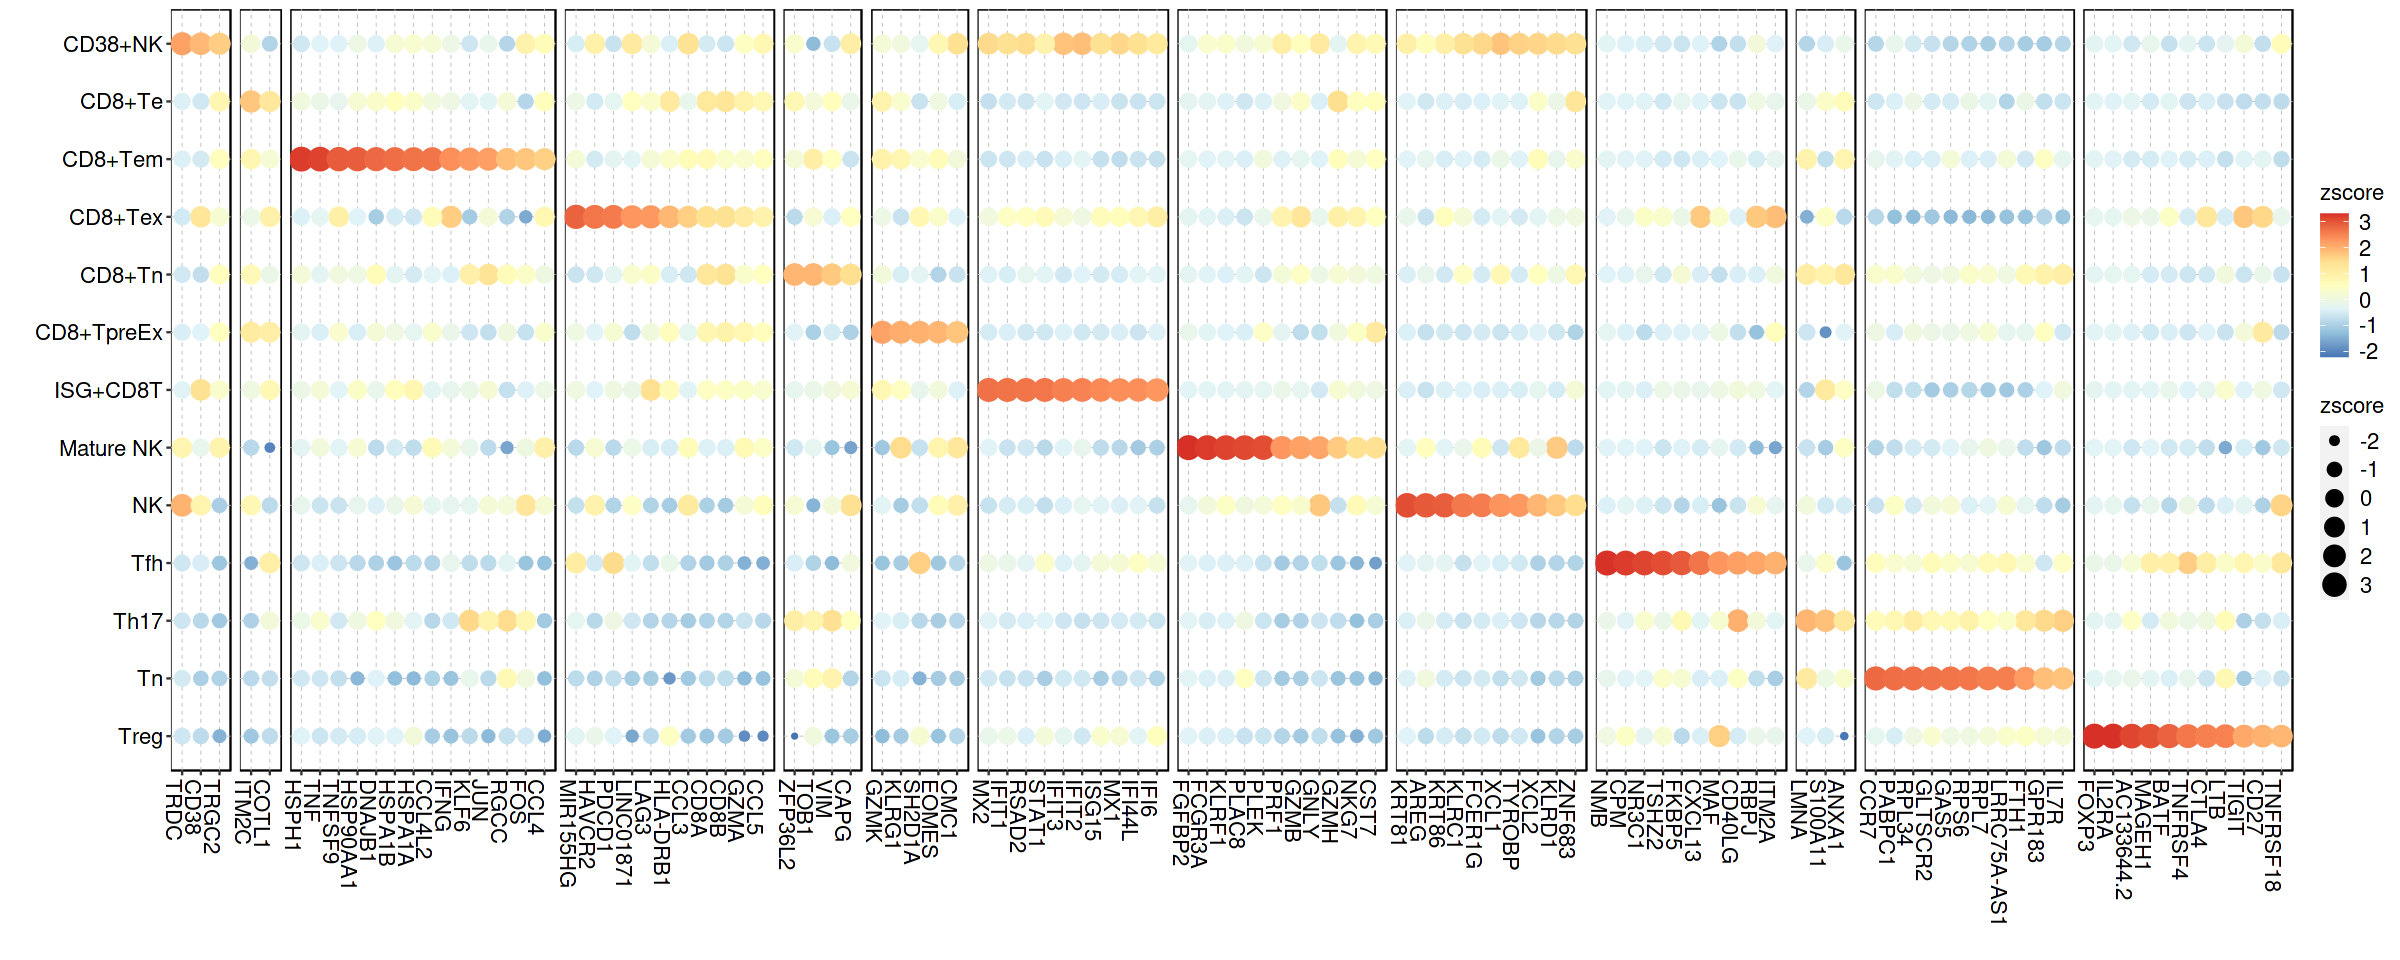

In [97]:
options(repr.plot.height = 8, repr.plot.width = 20)
M_heatmap <- Marker_heatmap(expr, unique(c('CD38',top10$gene)))
M_heatmap

In [3]:
Marker_heatmap

function (expr, gene) 
{
    expr <- expr[, c(gene, "label")]
    type_expr <- expr %>% tidyr::nest(-label) %>% dplyr::rename(expr = data) %>% 
        dplyr::mutate(colmeans = purrr::map(.x = expr, .f = function(.x) {
            colMeans(.x)
        }))
    type_mean_expr <- type_expr$colmeans %>% as.data.frame() %>% 
        tibble::remove_rownames() %>% t() %>% as.data.frame() %>% 
        tibble::remove_rownames()
    rownames(type_mean_expr) <- type_expr$label
    colnames(type_mean_expr) <- colnames(expr)[-ncol(expr)]
    sub_expr <- type_mean_expr
    sub_expr <- sub_expr %>% as.tibble() %>% dplyr::mutate_all(funs((. - 
        mean(.))/sd(.))) %>% t()
    colnames(sub_expr) <- type_expr$label
    get_label <- function(num) {
        v <- sub_expr[num, ]
        colnames(sub_expr)[which(v == max(v))]
    }
    sub_expr <- sub_expr %>% tibble::as.tibble() %>% dplyr::mutate(group = purrr::map_chr(1:length(gene), 
        get_label))
    sub_expr <- as.data.frame(sub_expr)
    rownames(sub_expr) <- gene
    sub_expr <- sub_expr %>% dplyr::mutate(gene = gene) %>% tidyr::gather(key = "cell_type", 
        value = "zscore", -group, -gene) %>% dplyr::arrange(group, 
        desc(zscore))
    p <- sub_expr %>% ggplot(aes(factor(gene, levels = unique(sub_expr$gene)), 
        factor(cell_type, levels = sort(unique(sub_expr$cell_type), 
            decreasing = T)))) + geom_point(aes(size = zscore, 
        colour = zscore)) + theme(strip.text.x = element_blank(), 
        axis.title = element_text(size = 15), axis.text = element_text(size = 13), 
        legend.title = element_text(size = 13), legend.text = element_text(size = 13), 
        axis.text.y = element_text(color = "black"), axis.text.x = element_text(color = "black", 
            angle = -90, hjust = 0), panel.background = element_rect(colour = "black", 
            fill = "white"), panel.grid = element_line(colour = "grey", 
            linetype = "dashed"), panel.grid.major = element_line(colour = "grey", 
            linetype = "dashed", size = 0.2)) + facet_grid(. ~ 
        group, scales = "free", space = "free") + scale_colour_distiller(palette = "RdYlBu") + 
        labs(x = "", y = "")
    return(p)
}
<bytecode: 0x55e992282870>
<environment: namespace:scibet>

In [98]:
pdf(file = './output/bulk/section_3/0.Tcell_Marker_heatmap.pdf',width = 20,height = 5)
print(M_heatmap)
dev.off()

Warning message:
“Use of `sub_expr$gene` is discouraged. Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged. Use `cell_type` instead.”


png 
  2

In [30]:
stemness <- c('SELL','LEF1','CD28','CD27','CCR7','IL7R','CXCR5')
activation <- c('IL2','CD38','ENTPD1','ICOS','TNFRSF9','XCL1')
effector <- c('GZMK','GZMH','GZMB','PRF1','GNLY','IFNG','FGFBP2')
differentiation <- c('ITGA1','ITGAE','ITGA2','ITGAL','ITGB2')
exhaustion <- c('PDCD1','TIGIT','LAG3','CTLA4','CD74','CXCL13','LAYN','MYO7A')
MHC_I <- c('HLA-A','HLA-B','HLA-C','HLA-E','HLA-F','HLA-G','HLA-H','HLA-J','HLA-K','HLA-L','HLA-N')
MHC_II <- c('HLA-DMA','HLA-DMB','HLA-DOA','HLA-DOB','HLA-DPA1','HLA-DPA2','HLA-DPA3','HLA-DPB1',
            'HLA-DPB2','HLA-DQA1','HLA-DQA2','HLA-DQB1','HLA-DQB2','HLA-DQB3','HLA-DRA','HLA-DRB1','HLA-DRB2','HLA-DRB3','HLA-DRB4')

### TAM 绘图

In [7]:
table(mergeData_TAM$cellType)


        cDC1         cDC2   Macro_C1QB Macro_CCL3L3 Macro_CXCL10  Macro_MARCO 
         595         1379         7421         3390         1770         1386 
  Macro_MT1H   Macro_SPP1    Mono_FCN1    mast_cell 
        1293         2962         2120         1914 

In [8]:
mergeData_TAM$cellType <- as.character(mergeData_TAM$cellType)

In [9]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 33)

In [10]:
mergeData_TAM$cellType <- factor(mergeData_TAM$cellType,
                                    levels = c('cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell'),
                                    labels = c('cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell'))

In [8]:
cellType_col[8:17]

[1] "#E6AB02" "#FC8D62" "#B3B3B3" "#FDB462" "#FFFFB3" "#FB9A99" "#CBD5E8"
 [8] "#33A02C" "#FB8072" "#FDC086"

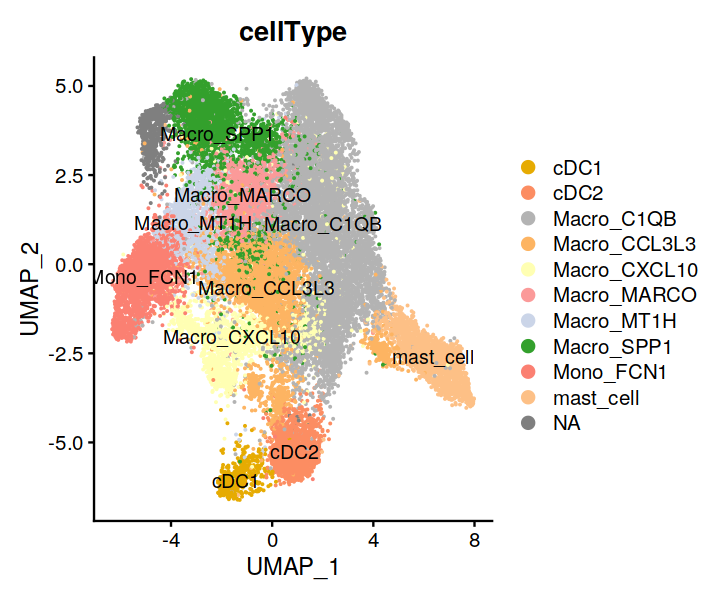

In [9]:
options(repr.plot.height = 5, repr.plot.width = 6)
dimP2 <- DimPlot(object = mergeData_TAM,reduction = 'umap',group.by = c('cellType'),cols = cellType_col[8:17], label = T)
dimP2

In [141]:
pdf(file = './output/bulk/section_3/0.TAMcell_DimPlot.pdf',width = 6,height = 5)
print(dimP2)
dev.off()

png 
  2

In [11]:
cellType <- as.character(mergeData_TAM$cellType)
names(cellType) <- colnames(mergeData_TAM)
cell_list <- split(colnames(mergeData_TAM),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)
mergeData_TAM_sub <- subset(mergeData_TAM,cells = sampleCell)

In [12]:
expr <- t(as.matrix(mergeData_TAM_sub@assays$RNA@data))
expr <- as.data.frame(expr)
expr$label <- mergeData_TAM_sub$cellType


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


In [13]:
etest_gene <- SelectGene(expr = expr,k = 200)

In [15]:
gene = c(etest_gene,'CXCL9')

 expr <- expr[, c(gene, "label")]
    type_expr <- expr %>% tidyr::nest(-label) %>% dplyr::rename(expr = data) %>% 
        dplyr::mutate(colmeans = purrr::map(.x = expr, .f = function(.x) {
            colMeans(.x)
        }))

    type_mean_expr <- type_expr$colmeans %>% as.data.frame() %>% 
        tibble::remove_rownames() %>% t() %>% as.data.frame() %>% 
        tibble::remove_rownames()
    rownames(type_mean_expr) <- type_expr$label
    colnames(type_mean_expr) <- colnames(expr)[-ncol(expr)]
    sub_expr <- type_mean_expr

    sub_expr <- sub_expr %>% tibble::as.tibble() %>% dplyr::mutate_all(funs((. - 
        mean(.))/sd(.))) %>% t()
    colnames(sub_expr) <- type_expr$label


    get_label <- function(num) {
        v <- sub_expr[num, ]
        colnames(sub_expr)[which(v == max(v))]
    }
    sub_expr <- sub_expr %>% tibble::as.tibble() %>% dplyr::mutate(group = purrr::map_chr(1:length(gene), 
        get_label))
    sub_expr <- as.data.frame(sub_expr)
    rownames(sub_expr) <- gene
    sub_expr <- sub_expr %>% dplyr::mutate(gene = gene) %>% tidyr::gather(key = "cell_type", 
        value = "zscore", -group, -gene) %>% dplyr::arrange(group, 
        desc(zscore))


Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -label`?”
Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` instead.
ℹ The signature and semantics have changed, see `?as_tibble`.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [25]:
subset(sub_expr,group=='Macro_CXCL10'& cell_type=='Macro_CXCL10')

group        gene     cell_type    zscore  
321 Macro_CXCL10 CXCL10   Macro_CXCL10 2.833416
322 Macro_CXCL10 CXCL11   Macro_CXCL10 2.815167
323 Macro_CXCL10 RSAD2    Macro_CXCL10 2.712608
324 Macro_CXCL10 GBP1     Macro_CXCL10 2.667177
325 Macro_CXCL10 IFIT2    Macro_CXCL10 2.646670
326 Macro_CXCL10 IFIT1    Macro_CXCL10 2.641120
327 Macro_CXCL10 MX1      Macro_CXCL10 2.614882
328 Macro_CXCL10 CXCL9    Macro_CXCL10 2.605526
329 Macro_CXCL10 IFIT3    Macro_CXCL10 2.590838
330 Macro_CXCL10 TNFSF10  Macro_CXCL10 2.506355
331 Macro_CXCL10 ISG15    Macro_CXCL10 2.445677
332 Macro_CXCL10 IFI44L   Macro_CXCL10 2.198224
333 Macro_CXCL10 CCL2     Macro_CXCL10 1.869285
334 Macro_CXCL10 IFI6     Macro_CXCL10 1.863220
335 Macro_CXCL10 IL4I1    Macro_CXCL10 1.551981
336 Macro_CXCL10 LGALS3BP Macro_CXCL10 1.440810
337 Macro_CXCL10 CYBB     Macro_CXCL10 1.360623
338 Macro_CXCL10 CD81     Macro_CXCL10 1.338804
340 Macro_CXCL10 MARCKS   Macro_CXCL10 1.241319
343 Macro_CXCL10 FGL2     Macro_CXCL10 1.217869

In [18]:
sub_expr_TOP10 = sub_expr %>% group_by(group) %>% top_n(n=9,wt=zscore)

In [19]:
length(unique(sub_expr_TOP10$gene))

[1] 81

In [22]:
library(tibble)

Warning message:
“Use of `sub_expr$gene` is discouraged.
ℹ Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged.
ℹ Use `cell_type` instead.”


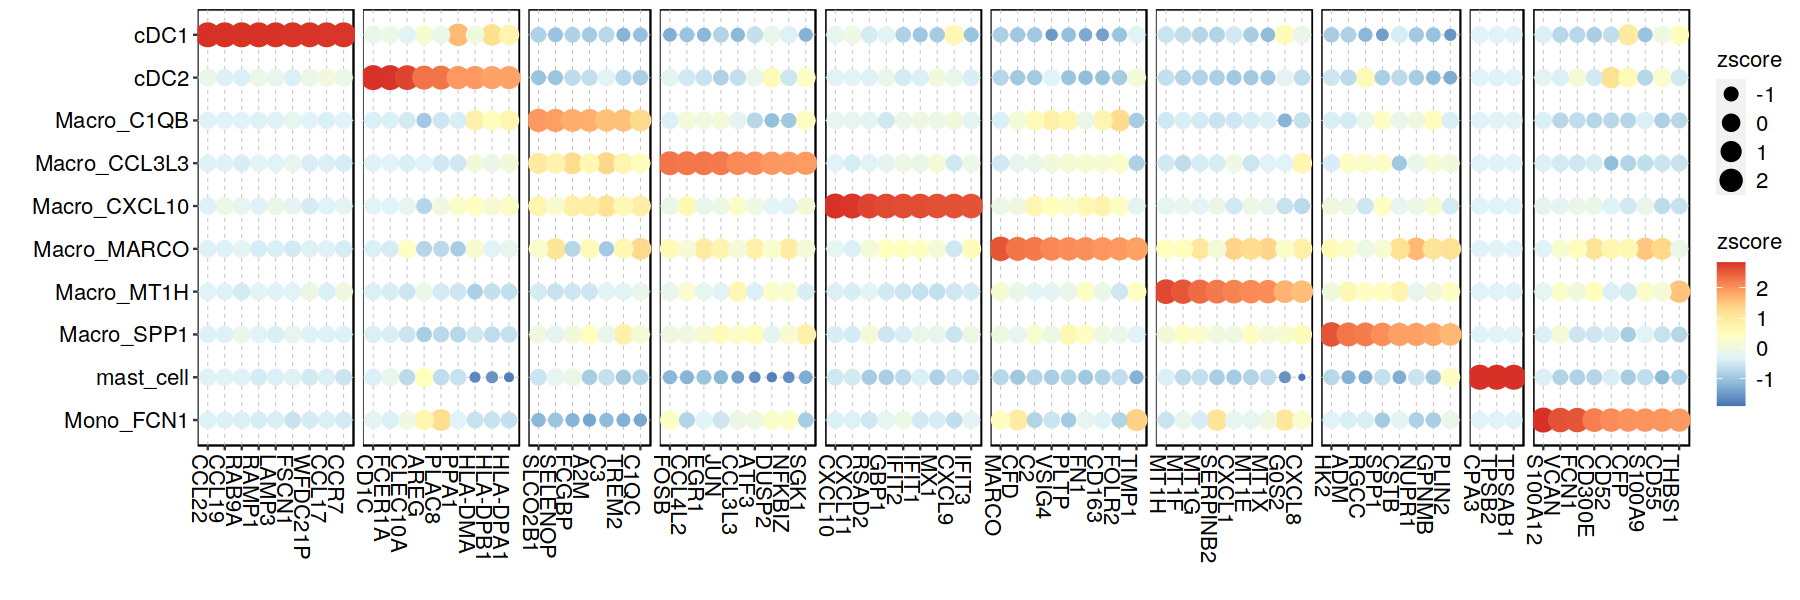

In [23]:
options(repr.plot.height = 5, repr.plot.width = 15)
M_heatmap2 <- Marker_heatmap(expr, unique(sub_expr_TOP10$gene))
M_heatmap2

In [24]:
pdf(file = './output/bulk/section_3/0.TAMcell_Marker_heatmap.pdf',width = 15,height = 5)
print(M_heatmap2)
dev.off()

Warning message:
“Use of `sub_expr$gene` is discouraged.
ℹ Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged.
ℹ Use `cell_type` instead.”


png 
  2

In [ ]:
M1_gene <- c('CCL5', 'CCR7', 'CD40', 'CD86', 'CXCL9', 'CXCL10', 'CXCL11', 'IDO1', 'IL1A','IL1B', 'IL6', 'IRF1', 'IRF5' , 'KYNU')
M2_gene <- c('CCL4', 'CCL13', 'CCL18', 'CCL20', 'CCL22', 'CD276', 'CLEC7A', 'CTSA', 'CTSB', 'CTSC', 'CTSD','FN1', 'IL4R', 'IRF4', 'LYVE1', 'MMP9', 'MMP14', 'MMP19', 'MSR1', 'TGFB1', 'TGFB2', 'TGFB3', 'TNFSF8', 'TNFSF12', 'VEGFA', 'VEGFB' , 'VEGFC')

### B cell 

In [107]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 33)

In [144]:
mergeData_B$cellType <- factor(mergeData_B$cellType,
                                    levels = c('B cell','Plasma cell','pDC'),
                                    labels = c('B cell','Plasma cell','pDC'))

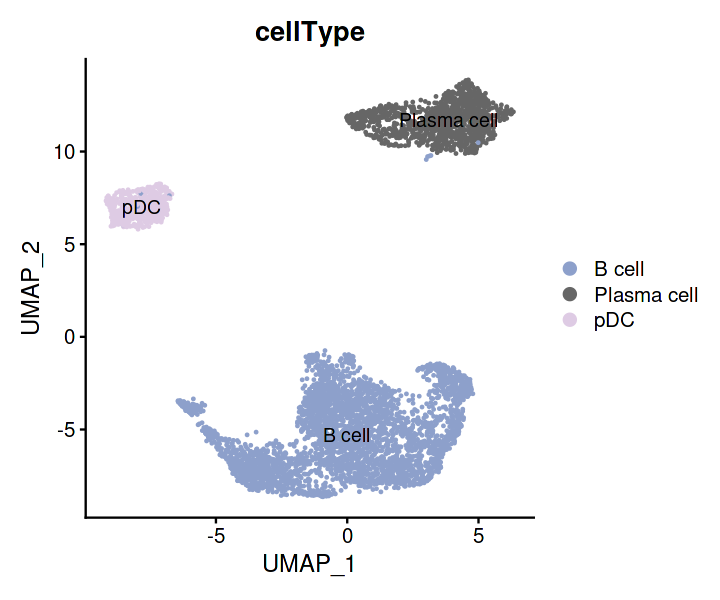

In [151]:
options(repr.plot.height = 5, repr.plot.width = 6)
dimP3 <- DimPlot(object = mergeData_B,reduction = 'umap',group.by = c('cellType'),cols = cellType_col[31:33], label = T)
dimP3

In [152]:
pdf(file = './output/bulk/section_3/0.Bcell_DimPlot.pdf',width = 6,height = 5)
print(dimP3)
dev.off()

png 
  2

In [110]:
expr <- t(as.matrix(mergeData_B@assays$RNA@data))
expr <- as.data.frame(expr)
expr$label <- mergeData_B$cellType

In [111]:
etest_gene <- SelectGene(expr = expr,k = 50)

Warning message:
“All elements of `...` must be named.
Did you want `data = -label`?”
Warning message:
“Use of `sub_expr$gene` is discouraged. Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged. Use `cell_type` instead.”


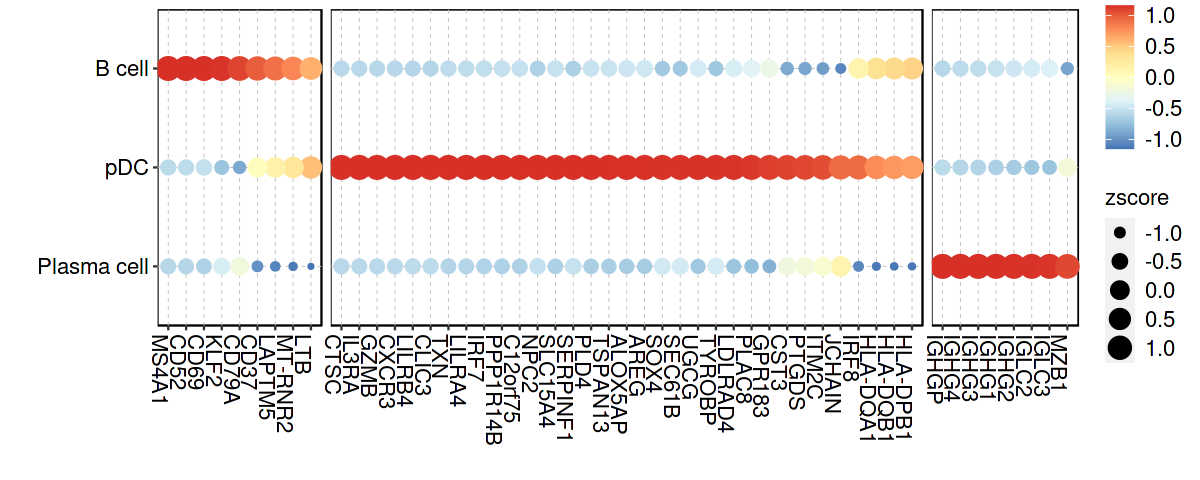

In [112]:
options(repr.plot.height = 4, repr.plot.width = 10)
M_heatmap3 <- Marker_heatmap(expr, etest_gene)
M_heatmap3

In [113]:
pdf(file = './output/bulk/section_3/0.Bcell_Marker_heatmap.pdf',width = 10,height = 5)
print(M_heatmap3)
dev.off()

Warning message:
“Use of `sub_expr$gene` is discouraged. Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged. Use `cell_type` instead.”


png 
  2

In [147]:
table(mergeData_CAF_m$cellType)


 CAF1  CAF2  CAF3  CAF4  CAF5  Endo myCAF 
 9463  1736  3966  3892  1779  3328  2241 

In [148]:
mergeData_CAF_m$cellType <- factor(mergeData_CAF_m$cellType,
                                    levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo'),
                                    labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo'))

In [157]:
mergeData_CAF_m <- RunUMAP(mergeData_CAF_m,reduction = "pca",dims = 1:50,seed.use = 12345)
mergeData_CAF_m <- FindNeighbors(mergeData_CAF_m,reduction = 'pca', dims = 1:50, verbose = FALSE)
mergeData_CAF_m <- RunTSNE(mergeData_CAF_m,reduction = 'pca',dims = 1:50,seed.use = 12345)
mergeData_CAF_m <- FindClusters(mergeData_CAF_m,resolution = 1, verbose = FALSE,random.seed=20210707)

18:42:59 UMAP embedding parameters a = 0.9922 b = 1.112

18:42:59 Read 26405 rows and found 50 numeric columns

18:42:59 Using Annoy for neighbor search, n_neighbors = 30

18:42:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:43:04 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpsUiPlc/file1e8ec010cf0990

18:43:04 Searching Annoy index using 1 thread, search_k = 3000

18:43:14 Annoy recall = 100%

18:43:16 Commencing smooth kNN distance calibration using 1 thread

18:43:18 Initializing from normalized Laplacian + noise

18:43:19 Commencing optimization for 200 epochs, with 1227654 positive edges

18:43:32 Optimization finished



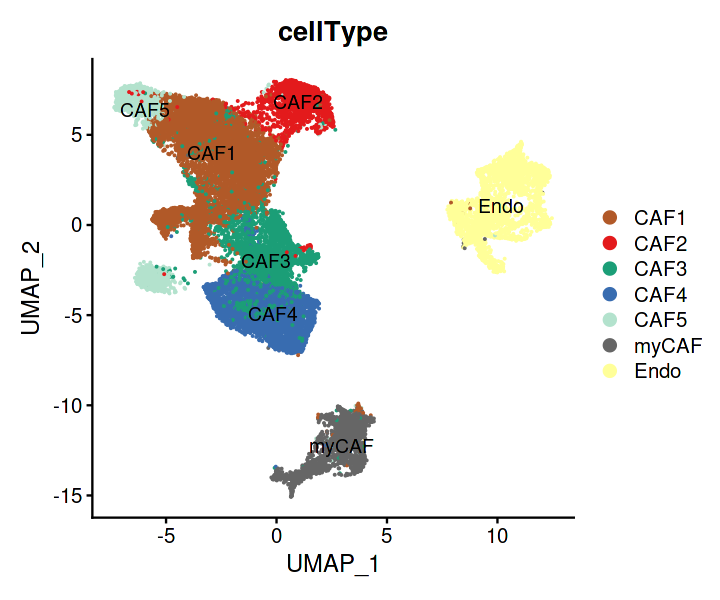

In [186]:
options(repr.plot.height = 5, repr.plot.width = 6)
dimPCAF <- DimPlot(object = mergeData_CAF_m,reduction = 'umap',group.by = c('cellType'),cols = cellType_col[1:7], label = T)
dimPCAF

In [187]:
pdf(file = './output/bulk/section_3/0.CAFcell_DimPlot.pdf',width = 6,height = 5)
print(dimPCAF)
dev.off()

png 
  2

## 合并数据

In [114]:
mergeData_immune <- merge(x = mergeData_B,y = list(mergeData_T,mergeData_TAM,mergeData_CAF_m))

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [115]:
DefaultAssay(mergeData_immune) <- 'RNA'
mergeData_immune <- NormalizeData(mergeData_immune, normalization.method = "LogNormalize")
mergeData_immune <- FindVariableFeatures(mergeData_immune, selection.method = "vst", nfeatures = 3000)
mergeData_immune <- ScaleData(mergeData_immune,vars.to.regress = c('nCount_RNA','mitoRatio'))
mergeData_immune <- RunPCA(mergeData_immune)


Regressing out nCount_RNA, mitoRatio

Centering and scaling data matrix

PC_ 1 
Positive:  CD74, HLA-DQB1, HLA-DPA1, TYROBP, HLA-DRB1, CTSS, HLA-DQA1, HLA-DRA, HLA-DPB1, FCER1G 
	   CYBB, AIF1, FCGR3A, C1QC, FCGR2A, SPI1, MS4A7, HLA-DMA, CD14, LST1 
	   MS4A6A, PLEK, RGS1, LYZ, CD68, HLA-DMB, CSF1R, CD163, MSR1, HLA-DRB5 
Negative:  SPARC, IGFBP7, CALD1, COL6A2, COL1A2, DCN, COL1A1, COL3A1, COL6A1, COL6A3 
	   C1R, C1S, AEBP1, TPM2, RARRES2, IGFBP4, THY1, FSTL1, SPARCL1, TAGLN 
	   CCDC80, MYL9, PCOLCE, COL5A2, LUM, SERPINH1, COL5A1, NNMT, BGN, IGFBP2 
PC_ 2 
Positive:  CST3, IER3, PLAUR, FTL, SERPINF1, TMEM176B, SERPING1, DCN, SOD2, FTH1 
	   C3, PSAP, BASP1, APOE, MAFB, C1S, CTSB, GPNMB, CTSL, C1R 
	   PDPN, TGFBI, TMEM176A, LUM, TIMP1, PLTP, FBLN1, CXCL8, COL1A1, TNFRSF12A 
Negative:  CDH5, ADGRL4, TM4SF18, VWF, CLEC14A, EMCN, SOX18, NOSTRIN, ROBO4, MMRN2 
	   CXorf36, PTPRB, ESAM, CALCRL, CYYR1, MYCT1, EGFL7, SHANK3, ECSCR, PCDH17 
	   KDR, ADGRF5, CD34, FLT1, TIE1, RBP7, AFAP1L1, 

In [8]:
mergeData_immune <- RunHarmony(object = mergeData_immune,group.by.vars = c('dataset'))

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [9]:
mergeData_immune <- RunUMAP(mergeData_immune,reduction = "harmony",dims = 1:50,seed.use = 12345)
mergeData_immune <- FindNeighbors(mergeData_immune,reduction = 'harmony', dims = 1:50, verbose = FALSE)
mergeData_immune <- RunTSNE(mergeData_immune,reduction = 'harmony',dims = 1:50,seed.use = 12345)
mergeData_immune <- FindClusters(mergeData_immune,resolution = 1, verbose = FALSE,random.seed=20210707)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:47:12 UMAP embedding parameters a = 0.9922 b = 1.112

14:47:12 Read 110917 rows and found 50 numeric columns

14:47:12 Using Annoy for neighbor search, n_neighbors = 30

14:47:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:47:30 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpsUiPlc/file1e8ec01bad6fd9

14:47:30 Searching Annoy index using 1 thread, search_k = 3000

14:48:22 Annoy recall = 100%

14:48:23 Commencing smooth kNN distance calibration using 1 thread

14

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



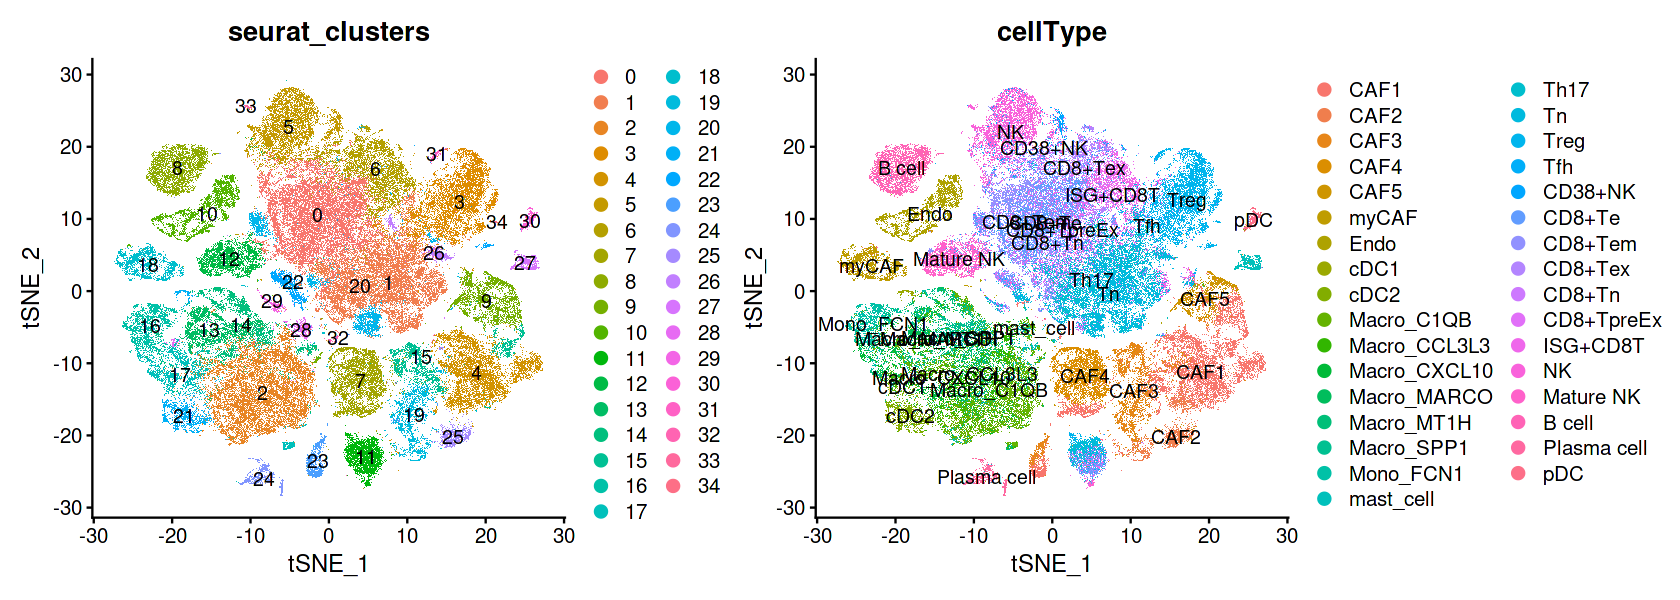

In [10]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_immune,reduction = 'tsne',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

In [106]:
genes_to_check = c('PTPRC', 'CD3D', 'CD3E','BTLA', 'CD4','CD8A','CXCR6','CD27','CD69','ITGAE','CXCL13','LAG3','GZMA',
                   'GZMK', 'CD79A', 'MS4A1' ,'PDCD1','TIGIT','CTLA4','IL2RA','FOXP3','IL7R','CCR7',
                   'IGHG1', 'MZB1', 'SDC1',
                   'CD68', 'CD163', 'CD14', 'JCHAIN','TCF4','IRF4',
                   'TPSAB1' , 'TPSB2',  # mast cells,
                   'RCVRN','FPR1' , 'VIM' ,
                   'C1QA',  'C1QB',  # mac
                   'S100A9', 'S100A8','SPP1', 'MMP1','ATF4','IL6','THBS2','CYR61','CXCL12',# monocyte
                   'LAMP3', 'IDO1','IDO2',## DC3 
                   'CD1E','CD1C', # DC2
                   'KRT86','GNLY', # NK 
                   'FGF7','MME', 'ACTA2','MYH11','TAGLN', ## fibo 
                   'DCN', 'LUM',  'GSN' , ## mouse PDAC fibo 
                   'FAP','FN1','THY1','COL1A1','COL3A1', 
                   'PECAM1', 'VWF',  ## endo 
                   'EPCAM' , 'KRT19', 'KRT18', 'CD24','MKI67' )
                   

In [132]:
table(mergeData_immune$seurat_clusters,mergeData_immune$cellType)

    
     B cell CAF1 CAF2 CAF3 CAF4 CAF5 CD38+NK CD8+Te CD8+Tem CD8+Tex CD8+Tn
  0       2    0    1    0    0    0     247   6739    2738     887    776
  1       3    2    5    0    0    1      57    339     503      14    473
  2       0    0    0    0    0    0       0      1       0       0      0
  3       0 6723  588 1995  240  121       0      1       6       1      0
  4       0    1    0    0    0    0       0      1       2       0      0
  5       0    0    0    0    2    0       0      3      22      49      2
  6       0    0    0    0    0    0     569    124     234      73    207
  7       0    2    1    0    0    0      62    168      75    1268     36
  8       5   32   32    4    0   18      18    452     337     133    180
  9       0  570    1   35 3038    5       0      0       0       1      0
  10   3372    1    0    0    0    0       0      0       6       0      0
  11      0    9    0    3    0    2       0     13       8       3      0
  12      0    0    

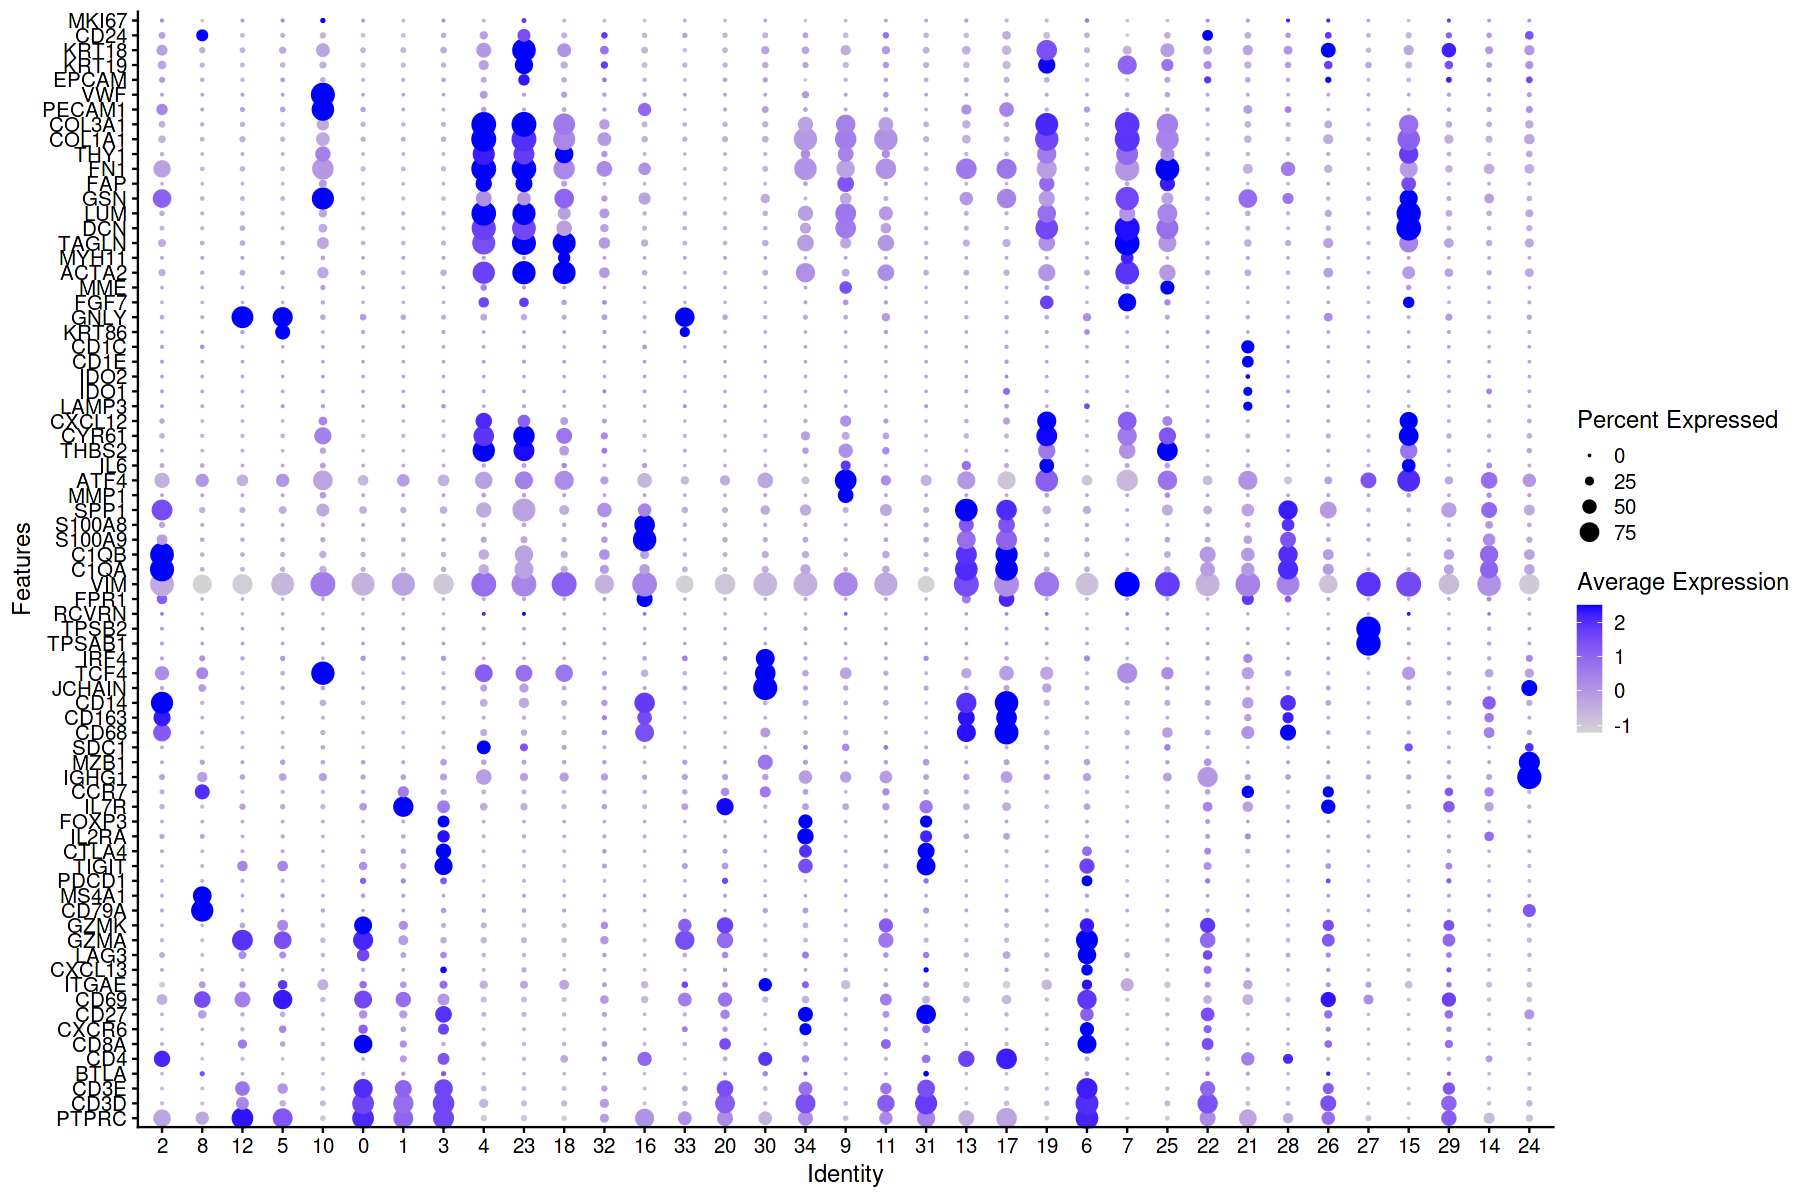

In [107]:
options(repr.plot.height = 10, repr.plot.width = 15)
DotPlot(mergeData_immune,group.by = 'seurat_clusters', features = unique(genes_to_check),assay = 'RNA',cluster.idents = T) + coord_flip()

In [318]:
#mergeData_immune <- subset(mergeData_immune,seurat_clusters %in% c(0:13,15:21,22:24,26:30))

In [319]:
table(mergeData_immune$cellType)


          B cell             CAF1             CAF2             CAF3 
            4164             9189             1602             3956 
            CAF4             CAF5          CD38+NK         CD8_Tpre 
            3715             1749              383             2913 
CD8+cytotoxic Te           CD8+Te          CD8+Tem          CD8+Tex 
             805             7122             3790             1653 
          CD8+Tn             cDC1             cDC2             cDC3 
            1227              361             1789              799 
            Endo         ISG+CD8T       Macro_C1QB     Macro_CCL3L3 
            3328             4596             7085             4343 
    Macro_CXCL10      Macro_MARCO       Macro_SPP1        mast_cell 
            1519             1688             2689             1582 
           ml_NK        Mono_FCN1            myCAF               NK 
            1749             3780             2230             6068 
     Plasma cell      Plasmablast

In [48]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 33)

In [100]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col2 <- sample(col_vector, 6)

In [8]:
mergeData_immune

An object of class Seurat 
49605 features across 110917 samples within 2 assays 
Active assay: RNA (47605 features, 3000 variable features)
 1 other assay present: integrated
 4 dimensional reductions calculated: pca, harmony, umap, tsne

In [46]:
table(mergeData_immune$cellType)


        CAF1         CAF2         CAF3         CAF4         CAF5        myCAF 
        9463         1736         3966         3892         1779         2241 
        Endo         cDC1         cDC2   Macro_C1QB Macro_CCL3L3 Macro_CXCL10 
        3328          595         1379         7421         3390         1770 
 Macro_MARCO   Macro_MT1H   Macro_SPP1    Mono_FCN1    mast_cell         Th17 
        1386         1293         2962         2120         1914         4976 
          Tn         Treg          Tfh       CD8+Te      CD8+Tem      CD8+Tex 
        8921         6080         1270         8038         4177         2463 
      CD8+Tn   CD8+TpreEx     ISG+CD8T           NK    Mature NK      CD38+NK 
        1724         3128         4401         5776         3042         1010 
      B cell  Plasma cell          pDC 
        3515         1227          534 

In [5]:
mergeData_immune$cellType <- factor(mergeData_immune$cellType,
                                    levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC'),
                                    labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC'))

In [6]:
mergeData_immune$cellType_rough <- mergeData_immune$cellType
mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('Th17','Tn','Treg','Tfh'),'CD4+ T',mergeData_immune$cellType_rough)
mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T'),'CD8+ T',mergeData_immune$cellType_rough)
mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('NK','Mature NK','CD38+NK'),'NK',mergeData_immune$cellType_rough)

mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_SPP1','Mono_FCN1','Macro_MT1H','mast_cell','cDC1','cDC2'),'myeloid',mergeData_immune$cellType_rough)
mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('Plasma cell','B cell','pDC'),'B',mergeData_immune$cellType_rough)
mergeData_immune$cellType_rough <- ifelse(mergeData_immune$cellType %in% c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo'),'stroma cell',mergeData_immune$cellType_rough)



In [7]:
table(mergeData_immune$cellType_rough)


          B      CD4+ T      CD8+ T     myeloid          NK stroma cell 
       5276       21247       23931       24230        9828       26405 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



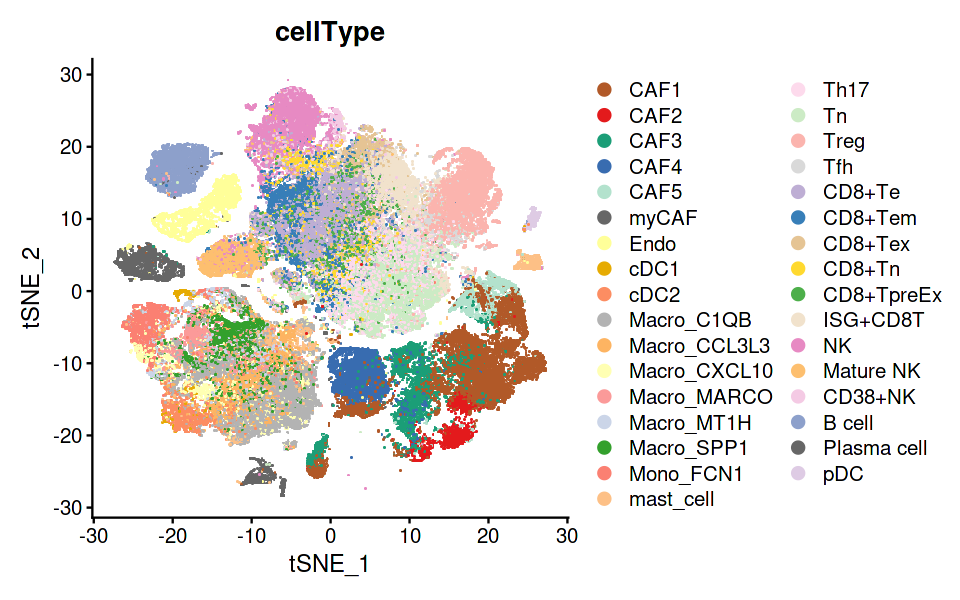

In [184]:
options(repr.plot.height = 5, repr.plot.width =8)
dimP5 <- DimPlot(object = subset(mergeData_immune,seurat_clusters !='11'),reduction = 'tsne',group.by = c('cellType'),cols = cellType_col,pt.size = 1.2, label = F)
dimP5

In [185]:
pdf(file = './output/bulk/section_3/0.AllImmunecell_DimPlot.pdf',width = 8,height = 5)
print(dimP5)
dev.off()

png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



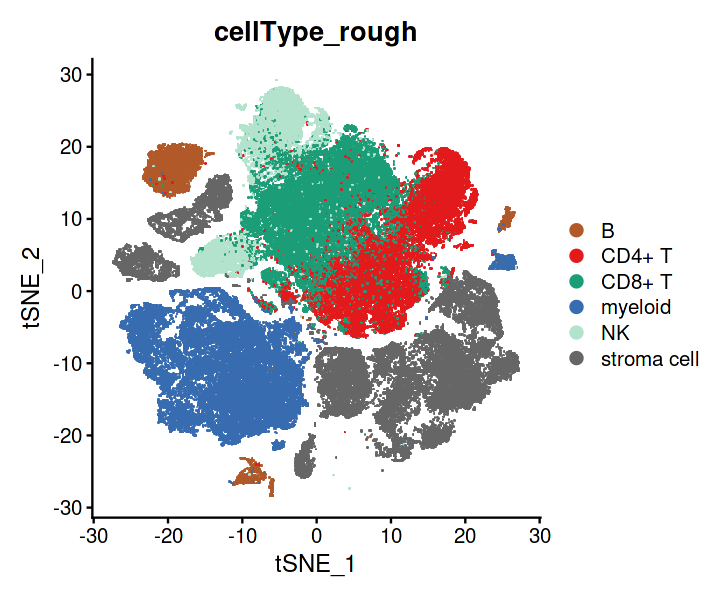

In [112]:
options(repr.plot.height = 5, repr.plot.width =6)
dimP4 <- DimPlot(object = subset(mergeData_immune,seurat_clusters !='11'),reduction = 'tsne',group.by = c('cellType_rough'),cols = cellType_col2,pt.size = 1, label = F)
dimP4

In [113]:
pdf(file = './output/bulk/section_3/0.AllImmunecell_DimPlot2.pdf',width = 6,height = 5)
print(dimP4)
dev.off()

png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



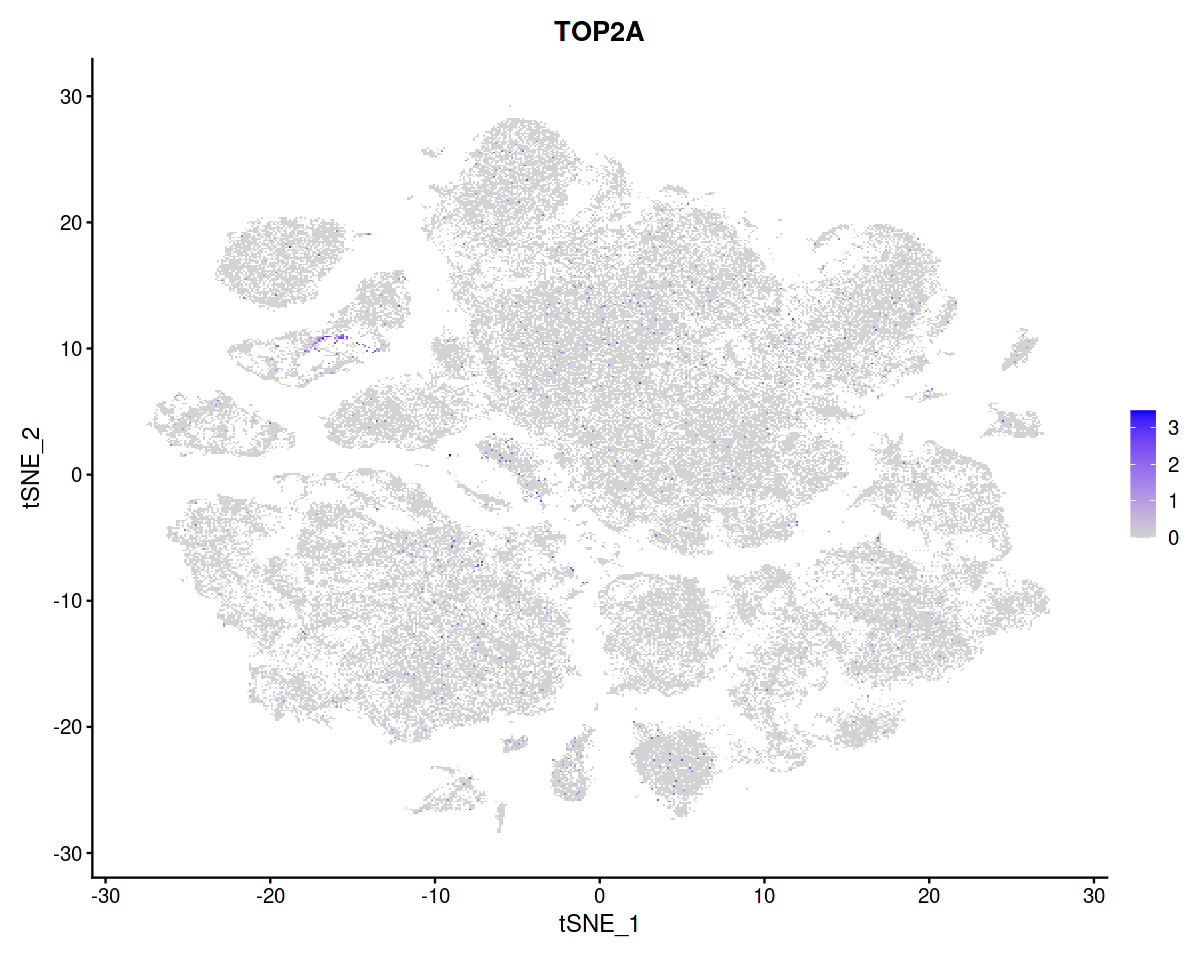

In [102]:
options(repr.plot.height = 8, repr.plot.width = 10)
FeaturePlot(object = mergeData_immune,features = 'TOP2A',reduction = 'tsne')

In [97]:
saveRDS(mergeData_immune,file = './output/1.sangleCell_pre/OV_mergeData_immune_final.RDS')

In [31]:
cell.prop <- as.data.frame(prop.table(table(mergeData_immune$cellType, mergeData_immune$patient_id)))
colnames(cell.prop)<-c("cellType","patient","proportion")
head(cell.prop)

cellType patient proportion  
1 B cell   EOC1005 8.035055e-04
2 CAF1     EOC1005 1.541609e-03
3 CAF2     EOC1005 9.343088e-06
4 CAF3     EOC1005 2.363801e-03
5 CAF4     EOC1005 9.343088e-06
6 CAF5     EOC1005 5.605853e-05

In [32]:
library(pheatmap)

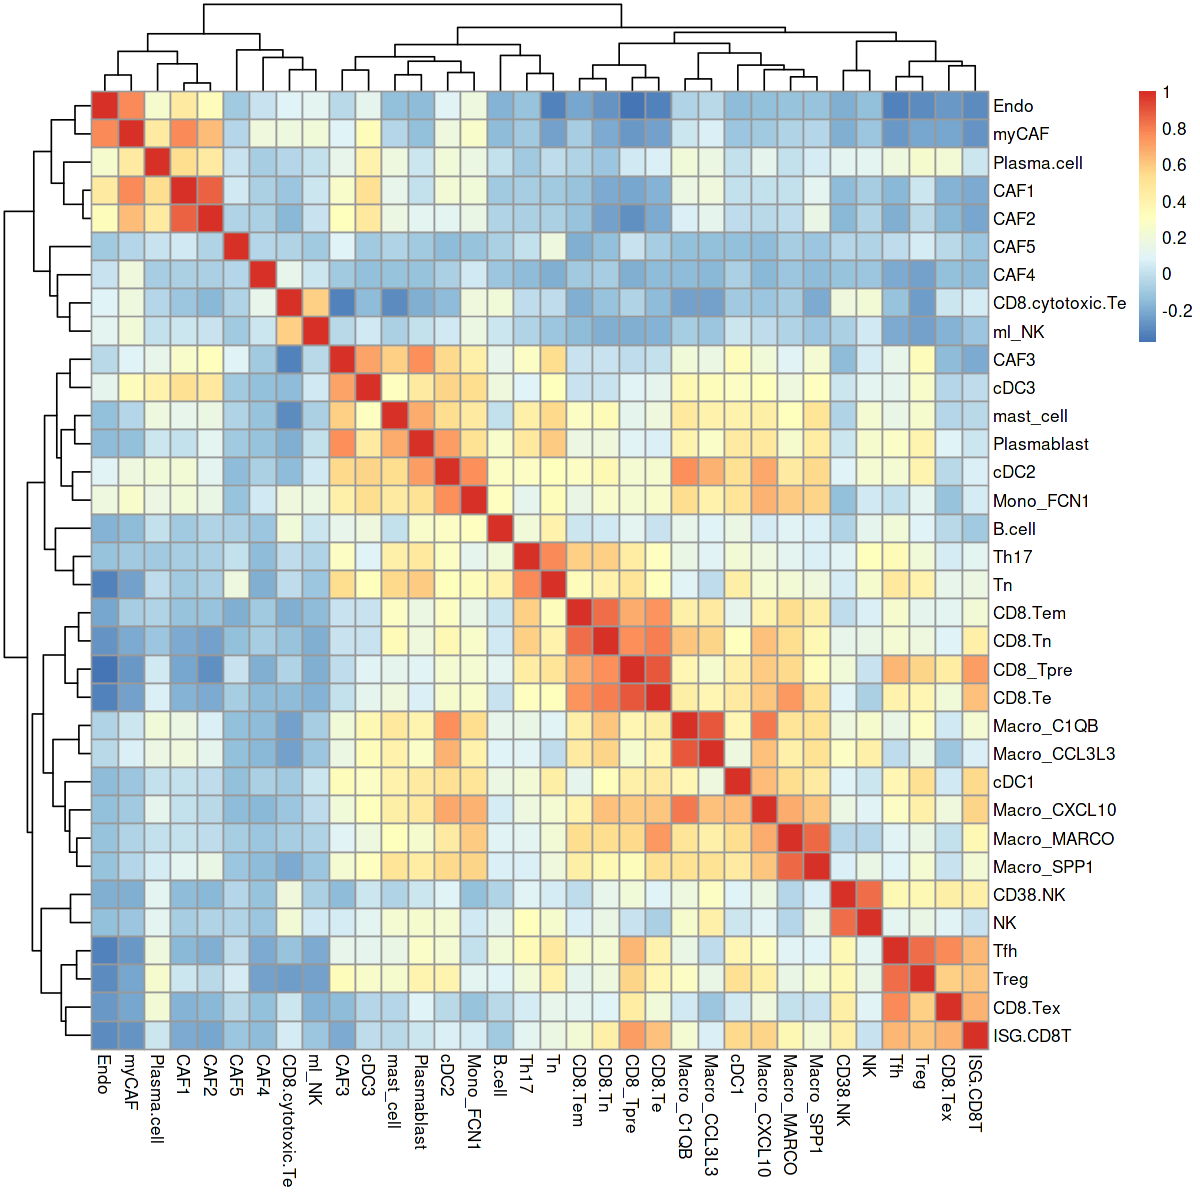

In [33]:
options(repr.plot.height = 10, repr.plot.width = 10)
pheatmap(cor(unstack(cell.prop, proportion~cellType)))

In [14]:
Idents(mergeData_immune) <- 'cellType'
cellMarkers <- FindAllMarkers(mergeData_immune,test.use = 'bimod',only.pos = T,logfc.threshold = 0.5)

Calculating cluster CAF1

Calculating cluster CAF2

Calculating cluster CAF3

Calculating cluster CAF4

Calculating cluster CAF5

Calculating cluster myCAF

Calculating cluster Endo

Calculating cluster cDC1

Calculating cluster cDC2

Calculating cluster Macro_C1QB

Calculating cluster Macro_CCL3L3

Calculating cluster Macro_CXCL10

Calculating cluster Macro_MARCO

Calculating cluster Macro_MT1H

Calculating cluster Macro_SPP1

Calculating cluster Mono_FCN1

Calculating cluster mast_cell

Calculating cluster Th17

Calculating cluster Tn

Calculating cluster Treg

Calculating cluster Tfh

Calculating cluster CD38+NK

Calculating cluster CD8+Te

Calculating cluster CD8+Tem

Calculating cluster CD8+Tex

Calculating cluster CD8+Tn

Calculating cluster CD8+TpreEx

Calculating cluster ISG+CD8T

Calculating cluster NK

Calculating cluster Mature NK

Calculating cluster B cell

Calculating cluster Plasma cell

Calculating cluster pDC



In [51]:
cellMarkers$cluster <- factor(cellMarkers$cluster,
                             
                                    levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC'),
                                    labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC')
                             )

In [63]:
cellMarkers <- cellMarkers[order(cellMarkers$cluster),]

In [64]:
head(cellMarkers)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene  
MMP11  0     4.203418   0.795 0.066 0         CAF1    MMP11 
COL1A1 0     3.839111   0.992 0.256 0         CAF1    COL1A1
COL1A2 0     3.749519   0.986 0.229 0         CAF1    COL1A2
LUM    0     3.539284   0.922 0.154 0         CAF1    LUM   
COL3A1 0     3.443201   0.975 0.211 0         CAF1    COL3A1
CTHRC1 0     3.295296   0.872 0.101 0         CAF1    CTHRC1

In [65]:
table(cellMarkers$cluster)


        CAF1         CAF2         CAF3         CAF4         CAF5        myCAF 
         488          345          512          594          800          497 
        Endo         cDC1         cDC2   Macro_C1QB Macro_CCL3L3 Macro_CXCL10 
         706          295          265          414          466          492 
 Macro_MARCO   Macro_MT1H   Macro_SPP1    Mono_FCN1    mast_cell         Th17 
         449          375          419          383          161          102 
          Tn         Treg          Tfh       CD8+Te      CD8+Tem      CD8+Tex 
          60          222          171          168          175          288 
      CD8+Tn   CD8+TpreEx     ISG+CD8T           NK    Mature NK      CD38+NK 
         148          134          286          196          218          239 
      B cell  Plasma cell          pDC 
         163           86          300 

In [66]:
cellMarkers <- subset(cellMarkers,!grepl(pattern = '^RP[LS]',gene))

In [67]:
top5 <- cellMarkers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
top5

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster     gene    
1   0             4.203418   0.795 0.066 0             CAF1        MMP11   
2   0             3.839111   0.992 0.256 0             CAF1        COL1A1  
3   0             3.749519   0.986 0.229 0             CAF1        COL1A2  
4   0             3.539284   0.922 0.154 0             CAF1        LUM     
5   0             3.443201   0.975 0.211 0             CAF1        COL3A1  
6   0             2.890896   0.986 0.527 0             CAF2        TIMP1   
7   0             2.888608   0.922 0.150 0             CAF2        CPE     
8   0             2.720115   0.729 0.091 0             CAF2        LOX     
9   0             2.573675   0.634 0.085 0             CAF2        ANGPTL4 
10  0             2.504788   0.918 0.382 0             CAF2        FN1     
11  0             3.706241   0.867 0.161 0             CAF3        MGP     
12  0             2.878124   0.844 0.127 0             CAF3        FBLN1   
13  0             2.740256   0.950 0.205 0             CAF3        DCN     
14  0             2.714126   0.956 0.186 0             CAF3        CCDC80  
15  0             2.630161   0.398 0.068 0             CAF3        APOD    
16  0             5.395914   0.904 0.021 0             CAF4        PLA2G2A 
17  0             3.773676   0.900 0.031 0             CAF4        C7      
18  0             3.646205   0.984 0.142 0             CAF4        C11orf96
19  0             3.416460   0.906 0.086 0             CAF4        SERPINE2
20  0             3.379072   0.969 0.238 0             CAF4        TAGLN   
21  0             4.752444   0.849 0.020 0             CAF5        GAL     
22  0             4.367226   0.718 0.023 0             CAF5        MMP1    
23  0             3.488482   0.584 0.077 0             CAF5        CXCL1   
24  0             3.342713   0.974 0.129 0             CAF5        PDLIM4  
25  0             3.319938   0.944 0.240 0             CAF5        CXCL8   
26  0             4.317626   0.796 0.024 0             myCAF       RGS5    
27  0             3.911288   0.738 0.127 0             myCAF       ADIRF   
28  0             3.598666   0.995 0.294 0             myCAF       IGFBP7  
29  0             3.287937   0.800 0.053 0             myCAF       NDUFA4L2
30  0             3.078828   0.901 0.235 0             myCAF       ACTA2   
⋮   ⋮             ⋮          ⋮     ⋮     ⋮             ⋮           ⋮       
136  0.000000e+00 3.738398   0.745 0.110  0.000000e+00 NK          GNLY    
137  0.000000e+00 2.798480   0.554 0.043  0.000000e+00 NK          XCL1    
138  0.000000e+00 2.664307   0.642 0.034  0.000000e+00 NK          TRDC    
139  0.000000e+00 2.661153   0.557 0.028  0.000000e+00 NK          KLRC1   
140  0.000000e+00 2.503175   0.631 0.108  0.000000e+00 NK          XCL2    
141  0.000000e+00 3.213314   0.683 0.010  0.000000e+00 Mature NK   FGFBP2  
142  0.000000e+00 2.949437   0.810 0.124  0.000000e+00 Mature NK   GNLY    
143  0.000000e+00 2.775518   0.968 0.312  0.000000e+00 Mature NK   NKG7    
144  0.000000e+00 2.654003   0.808 0.141  0.000000e+00 Mature NK   GZMB    
145  0.000000e+00 2.601119   0.748 0.154  0.000000e+00 Mature NK   PRF1    
146  0.000000e+00 2.544471   0.624 0.060  0.000000e+00 CD38+NK     TRDC    
147  0.000000e+00 2.064758   0.780 0.129  0.000000e+00 CD38+NK     KLRD1   
148 3.307021e-279 2.915609   0.567 0.139 1.574307e-274 CD38+NK     GNLY    
149 3.588754e-275 2.144304   0.472 0.066 1.708427e-270 CD38+NK     XCL1    
150 5.583256e-275 2.020500   0.602 0.131 2.657909e-270 CD38+NK     XCL2    
151  0.000000e+00 3.775955   0.545 0.045  0.000000e+00 B cell      IGHM    
152  0.000000e+00 3.527972   0.860 0.025  0.000000e+00 B cell      CD79A   
153  0.000000e+00 2.905650   0.697 0.014  0.000000e+00 B cell      MS4A1   
154  0.000000e+00 1.974515   0.536 0.061  0.000000e+00 B cell      CD79B   
155  0.000000e+00 1.945085   0.502 0.009  0.000000e+00 B cell      BANK1   
156  0.000000e+00 7.140680   0.889 0.342  0.000000e+

In [174]:
top2 <- cellMarkers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
head(top2)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene  
1 0     4.203418   0.795 0.066 0         CAF1    MMP11 
2 0     3.839111   0.992 0.256 0         CAF1    COL1A1
3 0     3.749519   0.986 0.229 0         CAF1    COL1A2
4 0     3.539284   0.922 0.154 0         CAF1    LUM   
5 0     3.443201   0.975 0.211 0         CAF1    COL3A1
6 0     3.295296   0.872 0.101 0         CAF1    CTHRC1

In [175]:
cellMap_list <- split(mergeData_immune$cellType,mergeData_immune$cellType_rough)

In [180]:
subset(top2,cluster%in%cellMap_list$B)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster     gene     
1   0.000000e+00 3.775955   0.545 0.045  0.000000e+00 B cell      IGHM     
2   0.000000e+00 3.527972   0.860 0.025  0.000000e+00 B cell      CD79A    
3   0.000000e+00 2.905650   0.697 0.014  0.000000e+00 B cell      MS4A1    
4   0.000000e+00 1.974515   0.536 0.061  0.000000e+00 B cell      CD79B    
5   0.000000e+00 1.945085   0.502 0.009  0.000000e+00 B cell      BANK1    
6   0.000000e+00 1.911422   0.873 0.463  0.000000e+00 B cell      CD37     
7   0.000000e+00 1.897072   0.527 0.008  0.000000e+00 B cell      TNFRSF13C
8   0.000000e+00 1.732071   0.650 0.229  0.000000e+00 B cell      CD83     
9   0.000000e+00 1.721063   0.534 0.103  0.000000e+00 B cell      CCR7     
10  0.000000e+00 1.697085   0.509 0.096  0.000000e+00 B cell      IRF8     
11  0.000000e+00 7.140680   0.889 0.342  0.000000e+00 Plasma cell IGLC2    
12  0.000000e+00 7.133636   0.917 0.181  0.000000e+00 Plasma cell IGHG1    
13  0.000000e+00 7.114281   0.920 0.234  0.000000e+00 Plasma cell IGHG3    
14  0.000000e+00 6.913001   0.958 0.473  0.000000e+00 Plasma cell IGKC     
15  0.000000e+00 6.868600   0.703 0.174  0.000000e+00 Plasma cell IGLC3    
16  0.000000e+00 6.148285   0.838 0.194  0.000000e+00 Plasma cell IGHG4    
17  0.000000e+00 5.603441   0.429 0.135  0.000000e+00 Plasma cell IGHA1    
18  0.000000e+00 5.309595   0.581 0.047  0.000000e+00 Plasma cell IGHGP    
19  0.000000e+00 4.684666   0.557 0.058  0.000000e+00 Plasma cell JCHAIN   
20  0.000000e+00 4.199298   0.561 0.027  0.000000e+00 Plasma cell IGHG2    
21  0.000000e+00 3.950545   0.918 0.155  0.000000e+00 pDC         GZMB     
22  0.000000e+00 3.853725   0.916 0.059  0.000000e+00 pDC         JCHAIN   
23  0.000000e+00 2.737405   0.699 0.086  0.000000e+00 pDC         PLAC8    
24  0.000000e+00 2.571017   0.736 0.273  0.000000e+00 pDC         IRF7     
25  0.000000e+00 2.492300   0.702 0.106  0.000000e+00 pDC         IRF8     
26  0.000000e+00 2.417610   0.644 0.003  0.000000e+00 pDC         LILRA4   
27  0.000000e+00 2.411832   0.659 0.054  0.000000e+00 pDC         TSPAN13  
28 6.875077e-292 2.678786   0.861 0.321 3.272880e-287 pDC         GPR183   
29 1.343161e-247 2.609248   0.320 0.005 6.394119e-243 pDC         TCL1A    
30 3.186448e-178 2.690138   0.603 0.142 1.516909e-173 pDC         AREG

In [68]:
length(unique(top5$gene))

[1] 136

In [69]:
test5 <- DotPlot(object = mergeData_immune,assay = 'RNA',
        features = unique(top5$gene),cols = c('blue','red'),group.by = 'cellType')

In [70]:
CAFmarker_data  <- test5$data
CAFmarker_data$EXP <- CAFmarker_data$avg.exp.scaled
CAFmarker_data$cluster <-  CAFmarker_data$id
CAFmarker_data$cluster <- factor(x = CAFmarker_data$cluster,          
                                    levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC'),
                                    labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC') 
                              )

In [87]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col2 <- sample(col_vector,6)

In [88]:
group <- c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                               'cDC1','cDC2','Macro_C1QB', 'Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell',
                                              'Th17','Tn','Treg','Tfh','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','NK','Mature NK','CD38+NK','B cell','Plasma cell','pDC') %>% as.data.frame() %>% 
  mutate(group=c(rep("stroma cell",7),rep("myeloid cell",10),rep("CD4+ T cell",4),rep("CD8+ T cell",6),rep("NK",3),rep("B cell",3))) %>%
  mutate(p="Cell group") %>%
  ggplot(aes(.,y=p,fill=group))+scale_fill_manual("group", values =  cellType_col2)+
  geom_tile() + 
  scale_y_discrete(position="right") +
  theme_minimal()+xlab(NULL) + ylab(NULL) +
  theme(axis.text.x = element_blank())+
  labs(fill = "Cell group")

In [89]:
library(aplot)

In [84]:
?geom_vline

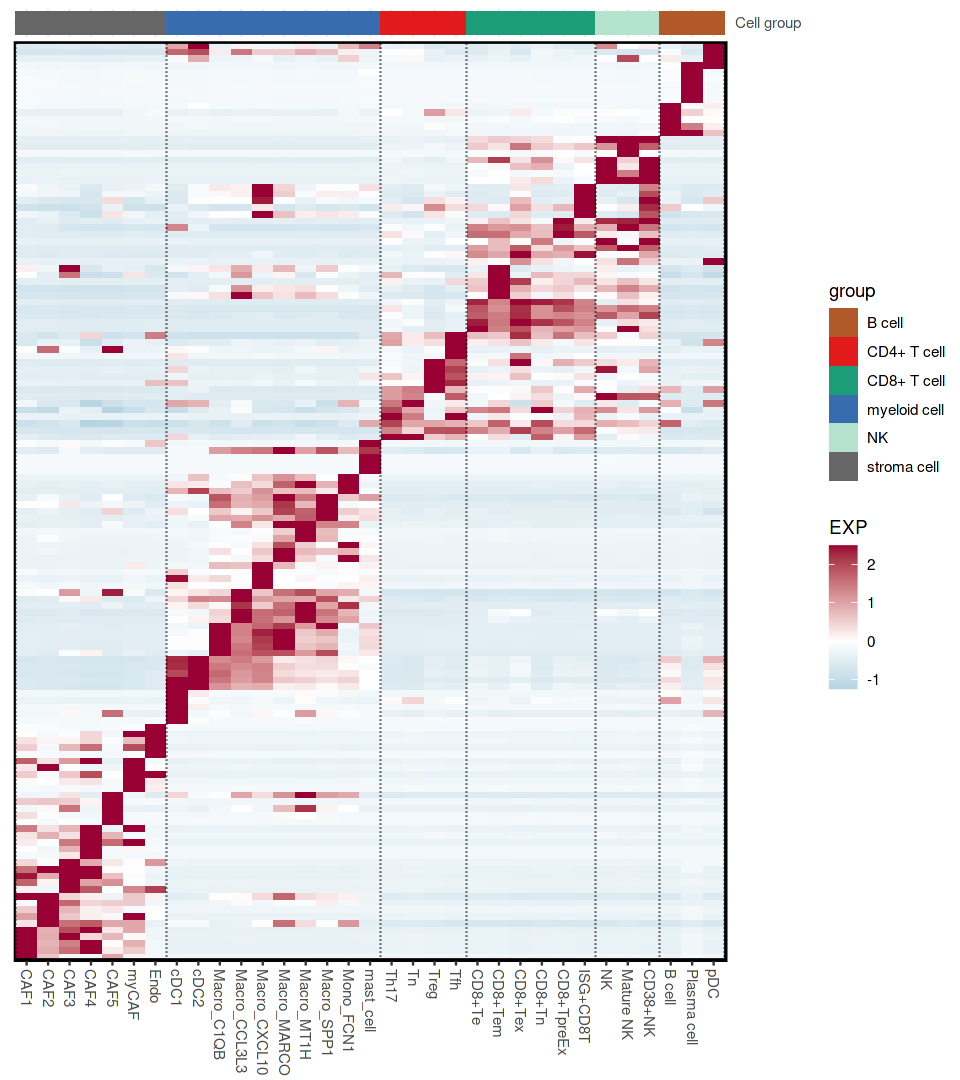

In [95]:
options(repr.plot.height = 9, repr.plot.width = 8)
p2 <- ggplot(CAFmarker_data, aes(y=features.plot, x=cluster, fill=EXP))+ 
geom_raster()+scale_fill_gradient2(low="#68AAC4", high="#990033", mid="white")+
theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5),axis.ticks.y = element_blank(),axis.text.y = element_blank())+xlab(NULL) + ylab(NULL)+
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))+
  geom_vline(xintercept=c(0.5,7.5,17.5,21.5,27.5,30.5,33.5),size=.5,linetype='dotted')
p3 <- p2 %>%
insert_top(group, height = .03) 
p3

In [96]:
pdf(file = './output/bulk/section_3/0.AllImmunecell_markerGeneHeatmap.pdf',width = 8,height = 9)
print(p3)
dev.off()

png 
  2

In [93]:

saveRDS(cellMarkers,file = './output/1.sangleCell_pre/OV_mergeData_immune_cellMarkers.RDS')

### 提取表达谱构建cibersortx 单细胞参考矩阵

In [99]:
#随机抽取部分细胞构建表达谱
cellType <- as.character(mergeData_immune$cellType)
names(cellType) <- colnames(mergeData_immune)
cell_list <- split(colnames(mergeData_immune),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)
cellType_sub <- cellType[sampleCell]
data <- GetAssayData(subset(mergeData_immune,cells = sampleCell),assay='RNA',slot='counts')
df <- t(t(data) / colSums(data) )* 1e6
df <- as.data.frame(x = df)

In [96]:
cellMarkers <- subset(cellMarkers,!grepl(pattern = '^RP[LS]',gene))
cellMarkers <- subset(cellMarkers,!grepl(pattern = '^MT-',gene))

In [100]:
#输出cibersortx 单细胞ref表达谱
df <- df[,sampleCell]
df <- df[unique(cellMarkers$gene),]
colnames(df) <- cellType_sub
x<- rownames(df)
rownames(df)<-NULL
final <- cbind(x,df)
colnames(final)[1]<- 'GeneSymbol'
y <- colnames(final)
y <- sub(pattern = '\\.[0-9]+',replacement = '',y)
colnames(final)<-NULL
final <- rbind(y,final)


In [104]:
write.table(x = final,file = './output/1.sangleCell_pre/mergeData_cibersort_singleCellRef.txt',sep = '\t',append = F,row.names = F,col.names = F)

In [128]:
rm(mergeData_B)
rm(mergeData_CAF_m)
rm(mergeData_T)
rm(mergeData_TAM)
gc()

used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells    9083402   485.2   15352684   820.0   15352684   820.0
Vcells 2456991395 18745.4 5105844562 38954.6 5443831217 41533.2

In [2]:
mergeData_immune <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immune_final.RDS')

In [3]:
head(mergeData_immune)

orig.ident nCount_RNA nFeature_RNA
AAACGGGCACTCTGTC-EOC443_iOme1_1 GSE165897  2251        787        
AAACGGGTCCAAACTG-EOC443_iOme1_1 GSE165897  2611        798        
AAAGATGGTCCATGAT-EOC443_iOme1_1 GSE165897  2403        896        
AAAGTAGGTGGCGAAT-EOC443_iOme1_1 GSE165897  2039        868        
AAAGTAGTCAGAGGTG-EOC443_iOme1_1 GSE165897  4706       1421        
AACCATGAGTGTCCCG-EOC443_iOme1_1 GSE165897  6567       1582        
AACTGGTGTAAGTAGT-EOC443_iOme1_1 GSE165897  4078       1581        
AAGACCTAGGGTCTCC-EOC443_iOme1_1 GSE165897  3566       1171        
AAGGCAGTCGCAAGCC-EOC443_iOme1_1 GSE165897  6614       1541        
AAGTCTGCATCGGAAG-EOC443_iOme1_1 GSE165897  4505       1414        
                                sample                  patient_id
AAACGGGCACTCTGTC-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAACGGGTCCAAACTG-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAAGATGGTCCATGAT-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAAGTAGGTGGCGAAT-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAAGTAGTCAGAGGTG-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AACCATGAGTGTCCCG-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AACTGGTGTAAGTAGT-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAGACCTAGGGTCTCC-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAGGCAGTCGCAAGCC-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
AAGTCTGCATCGGAAG-EOC443_iOme1_1 EOC443_interval_Omentum EOC443    
                                cellType_auto dataset   mitoRatio 
AAACGGGCACTCTGTC-EOC443_iOme1_1 B             GSE165897 0.03598401
AAACGGGTCCAAACTG-EOC443_iOme1_1 B             GSE165897 0.07200306
AAAGATGGTCCATGAT-EOC443_iOme1_1 B             GSE165897 0.03370787
AAAGTAGGTGGCGAAT-EOC443_iOme1_1 B             GSE165897 0.05885238
AAAGTAGTCAGAGGTG-EOC443_iOme1_1 plasma        GSE165897 0.03633659
AACCATGAGTGTCCCG-EOC443_iOme1_1 plasma        GSE165897 0.02010050
AACTGGTGTAAGTAGT-EOC443_iOme1_1 plasma        GSE165897 0.04291319
AAGACCTAGGGTCTCC-EOC443_iOme1_1 B             GSE165897 0.03056646
AAGGCAGTCGCAAGCC-EOC443_iOme1_1 plasma        GSE165897 0.02630783
AAGTCTGCATCGGAAG-EOC443_iOme1_1 plasma        GSE165897 0.02397336
                                log10GenesPerUMI riboRatio    RNA_snn_res.1
AAACGGGCACTCTGTC-EOC443_iOme1_1 0.8638575        0.0003598401 8            
AAACGGGTCCAAACTG-EOC443_iOme1_1 0.8493318        0.0007200306 8            
AAAGATGGTCCATGAT-EOC443_iOme1_1 0.8732692        0.0003370787 8            
AAAGTAGGTGGCGAAT-EOC443_iOme1_1 0.8879266        0.0005885238 8            
AAAGTAGTCAGAGGTG-EOC443_iOme1_1 0.8583972        0.0003633659 30           
AACCATGAGTGTCCCG-EOC443_iOme1_1 0.8380663        0.0002010050 30           
AACTGGTGTAAGTAGT-EOC443_iOme1_1 0.8860209        0.0004291319 30           
AAGACCTAGGGTCTCC-EOC443_iOme1_1 0.8638514        0.0003056646 8            
AAGGCAGTCGCAAGCC-EOC443_iOme1_1 0.8344019        0.0002630783 30           
AAGTCTGCATCGGAAG-EOC443_iOme1_1 0.8622640        0.0002397336 30           
                                seurat_clusters cellType RNA_snn_res.0.5
AAACGGGCACTCTGTC-EOC443_iOme1_1 8               B cell   0              
AAACGGGTCCAAACTG-EOC443_iOme1_1 8               B cell   8              
AAAGATGGTCCATGAT-EOC443_iOme1_1 8               B cell   1              
AAAGTAGGTGGCGAAT-EOC443_iOme1_1 8               B cell   0              
AAAGTAGTCAGAGGTG-EOC443_iOme1_1 30              pDC      4              
AACCATGAGTGTCCCG-EOC443_iOme1_1 30              pDC      4              
AACTGGTGTAAGTAGT-EOC443_iOme1_1 30              pDC      4              
AAGACCTAGGGTCTCC-EOC443_iOme1_1 8               B cell   1              
AAGGCAGTCGCAAGCC-EOC443_iOme1_1 30              pDC      4              
AAGTCTGCATCGGAAG-EOC443_iOme1_1 30              pDC      4              
                                integrated_snn_res.0.5
AAACGGGCACTCTGTC-EOC443_iOme1_1 NA                    
AAACGGGTCCAAACTG-EOC443_iOme1_1 NA                    
AAAGATGGTCCATGAT-

### 单独输出免疫细胞

In [335]:
mergeData_immune_sub <- subset(mergeData_immune,cellType %in% c('B cell','CD38+NK','CD8+Te','CD8+Te','CD8+Tex','CD8+Tn',
                                                            'CD8+TpreEx','cDC1','cDC2','ISG+CD8T','Macro_C1QB','Macro_CCL3L3','Macro_CXCL10',
                                                           'Macro_MARCO',   'Macro_MT1H',   'Macro_SPP1',    'mast_cell',    'Mature NK',
                                                           'Mono_FCN1','NK','pDC','Plasma cell','Tfh','Th17','Tn','Treg'))

In [346]:
cellType <- as.character(mergeData_immune_sub$cellType)
names(cellType) <- colnames(mergeData_immune_sub)
cell_list <- split(colnames(mergeData_immune_sub),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)
cellType_sub <- cellType[sampleCell]
data <- GetAssayData(subset(mergeData_immune_sub,cells = sampleCell),assay='RNA',slot='counts')
df <- t(t(data) / colSums(data) )* 1e6
df <- as.data.frame(x = df)

In [337]:
Idents(mergeData_immune_sub) <- 'cellType'
cellMarkers_immune <- FindAllMarkers(mergeData_immune_sub,test.use = 'bimod',only.pos = T,logfc.threshold = 0.5)

Calculating cluster B cell

Calculating cluster pDC

Calculating cluster Plasma cell

Calculating cluster Th17

Calculating cluster NK

Calculating cluster Tfh

Calculating cluster Tn

Calculating cluster CD8+TpreEx

Calculating cluster CD8+Te

Calculating cluster CD8+Tex

Calculating cluster Treg

Calculating cluster Mature NK

Calculating cluster ISG+CD8T

Calculating cluster CD8+Tn

Calculating cluster CD38+NK

Calculating cluster cDC2

Calculating cluster Macro_C1QB

Calculating cluster Mono_FCN1

Calculating cluster Macro_CCL3L3

Calculating cluster mast_cell

Calculating cluster cDC1

Calculating cluster Macro_SPP1

Calculating cluster Macro_CXCL10

Calculating cluster Macro_MT1H

Calculating cluster Macro_MARCO



In [344]:
length(unique(cellMarkers_immune$gene))

[1] 2128

In [343]:
cellMarkers_immune <- subset(cellMarkers_immune,!grepl(pattern = '^RP[LS]',gene))

In [347]:
df <- df[,sampleCell]
df <- df[unique(cellMarkers_immune$gene),]
colnames(df) <- cellType_sub
x<- rownames(df)
rownames(df)<-NULL
final <- cbind(x,df)
colnames(final)[1]<- 'GeneSymbol'
y <- colnames(final)
y <- sub(pattern = '\\.[0-9]+',replacement = '',y)
colnames(final)<-NULL
final <- rbind(y,final)


In [348]:
table(cellType)

cellType
      B cell      CD38+NK       CD8+Te      CD8+Tex       CD8+Tn   CD8+TpreEx 
        3515         1010         8038         2463         1724         3128 
        cDC1         cDC2     ISG+CD8T   Macro_C1QB Macro_CCL3L3 Macro_CXCL10 
         595         1379         4401         7421         3390         1770 
 Macro_MARCO   Macro_MT1H   Macro_SPP1    mast_cell    Mature NK    Mono_FCN1 
        1386         1293         2962         1914         3042         2120 
          NK          pDC  Plasma cell          Tfh         Th17           Tn 
        5776          534         1227         1270         4976         8921 
        Treg 
        6080 

In [349]:
write.table(x = final,file = './output/1.sangleCell_pre/mergeData_immune_cibersort_singleCellRef.txt',sep = '\t',append = F,row.names = F,col.names = F)

## 整合bulk数据构造细胞-细胞互作网络

In [984]:
cellMarkers <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immune_cellMarkers.RDS')

In [415]:
table(subset(cellMarkers,avg_log2FC>0.7)$cluster)


      B cell          pDC  Plasma cell         Th17           NK          Tfh 
          87          178           48           38           89           79 
     CD8+Tem           Tn   CD8+TpreEx       CD8+Te      CD8+Tex         Treg 
          88           23           56           68          128          113 
   Mature NK     ISG+CD8T       CD8+Tn      CD38+NK         cDC2   Macro_C1QB 
         101          147           58          118          150          251 
   Mono_FCN1 Macro_CCL3L3    mast_cell         cDC1   Macro_SPP1 Macro_CXCL10 
         231          283           79          188          254          297 
  Macro_MT1H  Macro_MARCO         CAF3         CAF1         CAF4        myCAF 
         245          283          336          286          376          312 
        CAF2         CAF5         Endo 
         202          488          426 

In [990]:
subset(cellMarkers,cluster=='Plasma cell')

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster    
IGLC2      0.000000e+00 7.1406800  0.889 0.342  0.000000e+00 Plasma cell
IGHG1      0.000000e+00 7.1336360  0.917 0.181  0.000000e+00 Plasma cell
IGHG3      0.000000e+00 7.1142810  0.920 0.234  0.000000e+00 Plasma cell
IGKC       0.000000e+00 6.9130014  0.958 0.473  0.000000e+00 Plasma cell
IGLC3      0.000000e+00 6.8686000  0.703 0.174  0.000000e+00 Plasma cell
IGHG4      0.000000e+00 6.1482854  0.838 0.194  0.000000e+00 Plasma cell
IGHA11     0.000000e+00 5.6034406  0.429 0.135  0.000000e+00 Plasma cell
IGHGP      0.000000e+00 5.3095951  0.581 0.047  0.000000e+00 Plasma cell
JCHAIN2    0.000000e+00 4.6846656  0.557 0.058  0.000000e+00 Plasma cell
IGHG2      0.000000e+00 4.1992982  0.561 0.027  0.000000e+00 Plasma cell
IGLL5      0.000000e+00 4.0892451  0.200 0.006  0.000000e+00 Plasma cell
MZB11      0.000000e+00 3.8354376  0.769 0.050  0.000000e+00 Plasma cell
SSR41      0.000000e+00 2.3538791  0.845 0.691  0.000000e+00 Plasma cell
DERL31     0.000000e+00 2.2377487  0.540 0.047  0.000000e+00 Plasma cell
XBP11      0.000000e+00 1.8812588  0.618 0.441  0.000000e+00 Plasma cell
CD79A1     0.000000e+00 1.6466271  0.448 0.047  0.000000e+00 Plasma cell
PRDX4      0.000000e+00 1.4592000  0.557 0.297  0.000000e+00 Plasma cell
FKBP21     0.000000e+00 1.2722393  0.551 0.409  0.000000e+00 Plasma cell
FCRL5      0.000000e+00 0.9867289  0.274 0.004  0.000000e+00 Plasma cell
TNFRSF17   0.000000e+00 0.9738170  0.271 0.003  0.000000e+00 Plasma cell
JSRP1      0.000000e+00 0.8977022  0.221 0.005  0.000000e+00 Plasma cell
SEC11C    7.523273e-304 1.4263141  0.527 0.287 3.581454e-299 Plasma cell
POU2AF11  8.441529e-283 0.7785242  0.248 0.012 4.018590e-278 Plasma cell
FKBP11    8.624848e-278 1.4059631  0.508 0.242 4.105859e-273 Plasma cell
HSP90B11  6.572277e-254 1.1577226  0.621 0.582 3.128733e-249 Plasma cell
CPNE51    8.842304e-188 0.6473061  0.216 0.019 4.209379e-183 Plasma cell
IGHM2     8.683453e-186 3.7484960  0.304 0.058 4.133758e-181 Plasma cell
HERPUD12  1.692577e-184 1.1369856  0.595 0.564 8.057512e-180 Plasma cell
SELENOS1  3.267988e-169 0.9943967  0.418 0.254 1.555726e-164 Plasma cell
IGLC7     1.553532e-163 1.9885516  0.131 0.007 7.395591e-159 Plasma cell
⋮         ⋮             ⋮          ⋮     ⋮     ⋮             ⋮          
PIM2      1.468770e-63  0.6235476  0.305 0.122 6.992077e-59  Plasma cell
HIST1H2BG 1.902807e-63  0.5982538  0.132 0.031 9.058313e-59  Plasma cell
ATP5PF    6.426494e-58  0.8044843  0.255 0.111 3.059333e-53  Plasma cell
ERGIC3    3.683938e-57  0.5248054  0.394 0.350 1.753739e-52  Plasma cell
ATP5MF    4.089559e-57  0.8095112  0.258 0.112 1.946835e-52  Plasma cell
MANF      8.862995e-57  0.6159801  0.438 0.354 4.219229e-52  Plasma cell
ATP5IF1   8.846928e-56  0.8088772  0.240 0.100 4.211580e-51  Plasma cell
S100A1    3.388758e-55  0.6189219  0.131 0.039 1.613218e-50  Plasma cell
ATP5MD    5.522358e-55  0.7755167  0.259 0.120 2.628918e-50  Plasma cell
ATP5MC3   2.776464e-54  0.7867923  0.257 0.113 1.321736e-49  Plasma cell
WFDC2     4.724145e-54  0.8370482  0.442 0.258 2.248929e-49  Plasma cell
SEL1L31   2.292066e-53  0.5066308  0.253 0.100 1.091138e-48  Plasma cell
ITM2C1    3.050852e-52  0.7770173  0.430 0.277 1.452358e-47  Plasma cell
QPRT      4.169284e-52  0.5068900  0.178 0.103 1.984788e-47  Plasma cell
SDF2L1    5.367389e-51  0.5996535  0.452 0.358 2.555145e-46  Plasma cell
CPEB4     1.089935e-47  0.5283275  0.222 0.156 5.188637e-43  Plasma cell
CD241     9.519077e-46  0.7156871  0.231 0.113 4.531557e-41  Plasma cell
FOLR1     2.064072e-44  0.5159249  0.124 0.034 9.826014e-40  Plasma cell
ATP5PO    1.279769e-43  0.6355786  0.240 0.113 6.092339e-39  Plasma cell
PABPC4    9.033777e-41  0.5232884  0.402 0.358 4.300530e-36  Plasma cell
ATP5MG    1.251803e-40  0.6243392  0.312 0.163 5.959206e-36  Plasma cell
HIST1H1C1 1.520512e-40  0.6990238  0.260 0.194 7.238399e-36  Plasma cell
ATP5MPL   3.439424e-39  0.5926422  0.262 0.134 1.637338e-34  Plasma 

In [142]:
length(unique(cellMarkers$gene))

[1] 3874

In [143]:
'CXCR3' %in% cellMarkers$gene

[1] TRUE

In [416]:
cellMarker_list <- subset(cellMarkers,avg_log2FC>0.5)
cellMarker_list <- split(cellMarker_list$gene,cellMarker_list$cluster)

In [417]:
cellMarker_list$`B cell`

[1] "IGHM"          "CD79A"         "MS4A1"         "CD79B"        
  [5] "BANK1"         "CD37"          "TNFRSF13C"     "CD83"         
  [9] "CCR7"          "IRF8"          "LINC00926"     "VPREB3"       
 [13] "IGHD"          "ADAM28"        "KLF2"          "AL928768.3"   
 [17] "GLTSCR2"       "TCL1A"         "GAS5"          "LAPTM5"       
 [21] "SMIM14"        "ARHGAP24"      "POU2F2"        "CTC-575D19.1" 
 [25] "SPIB"          "BLK"           "ORAI2"         "CD74"         
 [29] "EEF1B2"        "SWAP70"        "TNFRSF13B"     "HVCN1"        
 [33] "HLA-DQB1"      "CD22"          "BASP1"         "HLA-DRA"      
 [37] "RALGPS2"       "CD24"          "CHPT1"         "EZR"          
 [41] "GNG7"          "ZFAS1"         "LY9"           "SMAP2"        
 [45] "MEF2C"         "SELL"          "SYNGR2"        "RBM38"        
 [49] "CXCR4"         "TMEM243"       "IGHA1"         "EEF2"         
 [53] "CD19"          "BCL11A"        "RP11-371A22.1" "CD40"         
 [57] "EEF1A1"        "FCMR"          "P2RX5"         "POU2AF1"      
 [61] "KLK1"          "LINC01781"     "FCRLA"         "IFT57"        
 [65] "NAPSB"         "SNX2"          "LSM7"          "STAG3"        
 [69] "BCAS4"         "LTB"           "CXCR5"         "LYL1"         
 [73] "FAU"           "HLA-DPB1"      "HLA-DOB"       "HHEX"         
 [77] "AC079767.4"    "BLNK"          "FCER2"         "BTK"          
 [81] "SCIMP"         "RACK1"         "HLA-DQA1"      "LINC02397"    
 [85] "PAX5"          "UBA52"         "CD52"          "MARCH1"       
 [89] "CLECL1"        "PHACTR1"       "SNHG5"         "MT-RNR2"      
 [93] "COBLL1"        "RASGRP2"       "AIM2"          "CPNE5"        
 [97] "DRAM2"         "PKIG"          "CXXC5"         "STRBP"        
[101] "RCSD1"         "TOR3A"         "LRRC75A-AS1"   "SMARCB1"      
[105] "NFKBID"        "HLA-DMA"       "CCDC50"        "STX7"         
[109] "STK17A"        "SNHG6"         "TSC22D3"       "TPD52"        
[113] "RIC3"          "SLC25A6"       "EIF3L"         "PLEKHF2"      
[117] "PRKCB"         "CD72"          "C6orf48"       "TMEM154"      
[121] "BTG1"          "PIKFYVE"       "HLA-DMB"       "PRDM2"        
[125] "SYPL1"         "SMDT1"         "GAPT"          "C11orf31"     
[129] "RP11-705C15.2" "LIMD2"         "CD70"          "JCHAIN"       
[133] "SNHG8"         "CD69"          "ARRDC2"        "LYN"          
[137] "C7orf50"       "SNHG7"         "TMEM156"       "RP11-386I14.4"
[141] "LY86"          "ITSN2"         "PMAIP1"        "CTSH"         
[145] "EIF3E"         "PLAC8"         "TCOF1"         "HERPUD1"      
[149] "ISG20"         "ODC1"          "ATP2B1"        "BIRC3"        
[153] "RHOH"          "IDI1"          "INPP5D"        "EVI2B"        
[157] "DDIT3"         "C19orf43"      "YPEL5"         "SNHG3"        
[161] "RP11-425L10.1" "TXNIP"         "RIPOR2"

In [5]:
top10 <- cellMarkers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

In [6]:
subset(top10,cluster=='Macro_CXCL10')

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster      gene    
1  0     4.534423   0.677 0.058 0         Macro_CXCL10 CXCL10  
2  0     2.722177   0.348 0.025 0         Macro_CXCL10 CXCL9   
3  0     2.550560   0.417 0.016 0         Macro_CXCL10 CXCL11  
4  0     2.396839   0.305 0.022 0         Macro_CXCL10 CCL8    
5  0     2.370028   0.843 0.245 0         Macro_CXCL10 C1QB    
6  0     2.319135   0.793 0.172 0         Macro_CXCL10 C1QC    
7  0     2.298855   0.615 0.115 0         Macro_CXCL10 IFIT2   
8  0     2.290010   0.842 0.251 0         Macro_CXCL10 C1QA    
9  0     2.277262   0.934 0.554 0         Macro_CXCL10 ISG15   
10 0     2.247290   0.327 0.027 0         Macro_CXCL10 APOBEC3A

In [344]:
head(top10)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene     
1 0     3.731405   0.543 0.048 0         B cell  IGHM     
2 0     3.559311   0.854 0.027 0         B cell  CD79A    
3 0     2.903668   0.684 0.014 0         B cell  MS4A1    
4 0     1.956015   0.512 0.063 0         B cell  CD79B    
5 0     1.933993   0.474 0.010 0         B cell  BANK1    
6 0     1.893719   0.501 0.008 0         B cell  TNFRSF13C

Warning message:
“All elements of `...` must be named.
Did you want `data = -label`?”
Warning message:
“Use of `sub_expr$gene` is discouraged. Use `gene` instead.”
Warning message:
“Use of `sub_expr$cell_type` is discouraged. Use `cell_type` instead.”


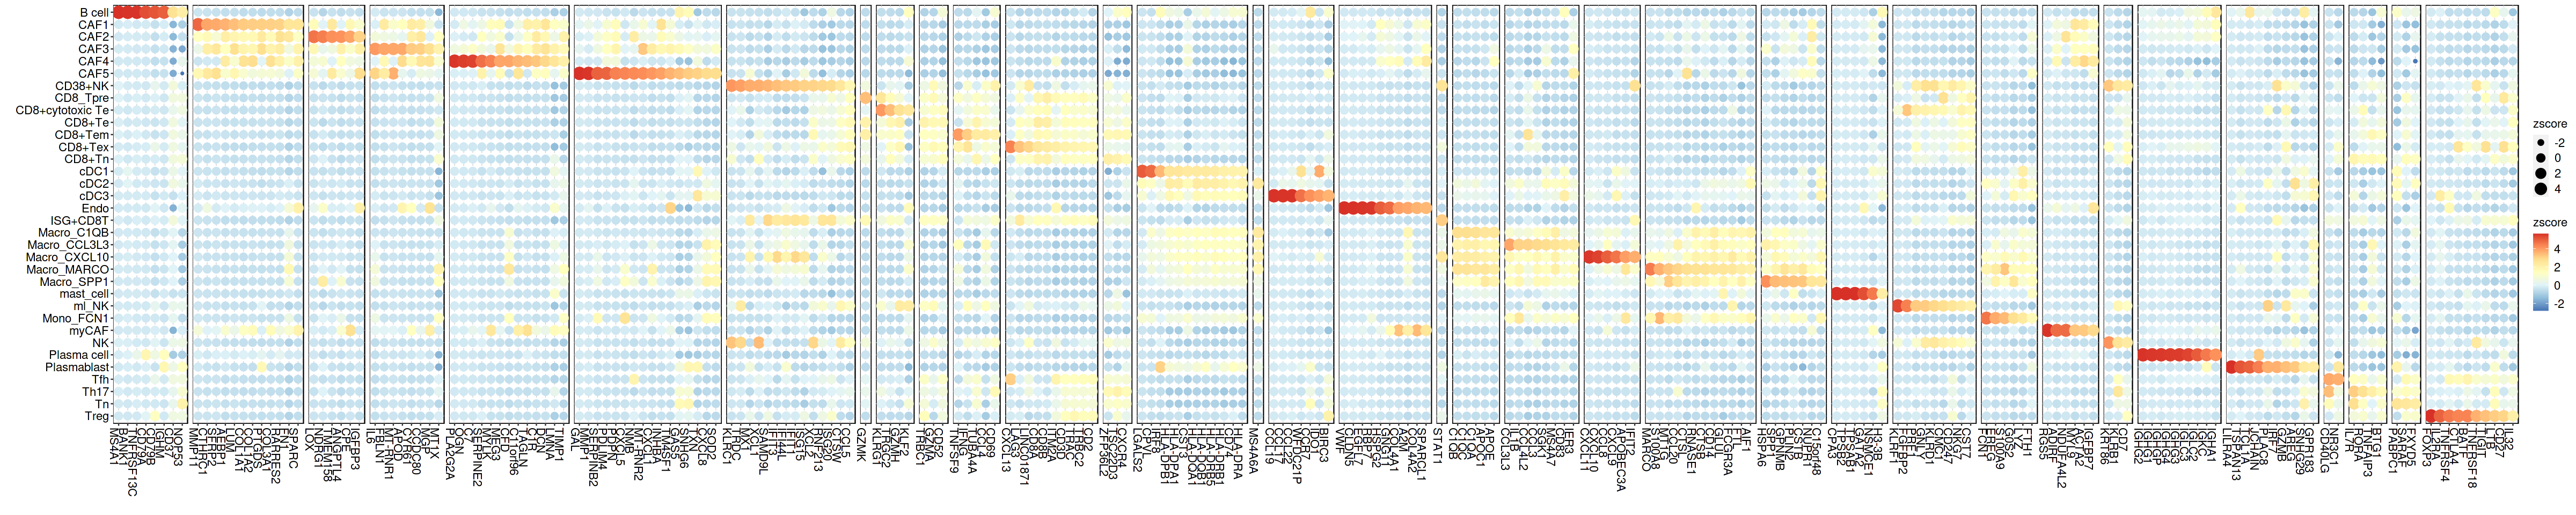

In [347]:
options(repr.plot.height = 8, repr.plot.width = 40)
M_heatmap2 <- Marker_heatmap(expr, unique(c(top10$gene)))
M_heatmap2

#### 提取TCGA Bulk和 单细胞数据的共享基因进行后续分析

In [3]:
TCGA_OV_TPM_log <- readRDS(file = './data/bulk/TCGA_OV_TPM_log2.RDS')
dim(TCGA_OV_TPM_log)

[1] 32936   379

In [4]:
DefaultAssay(mergeData_immune) <- 'RNA'

In [981]:
cellType <- as.character(mergeData_immune$cellType)
names(cellType) <- colnames(mergeData_immune)
cell_list <- split(colnames(mergeData_immune),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)

In [982]:
mergeData_immune_sub <- subset(x =mergeData_immune,cells =  sampleCell)

In [983]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))
expr <- t(as.matrix(mergeData_immune_sub@assays$RNA@data))
expr <- as.data.frame(expr)
expr$label <- mergeData_immune_sub$cellType
etest_gene <- SelectGene(expr = expr,k = 5000)

In [987]:
geneboth <- intersect(rownames(TCGA_OV_TPM_log),etest_gene)
length(geneboth)

[1] 4884

In [988]:
'CTGF' %in% geneboth

[1] TRUE

In [989]:
'CXCR3' %in% etest_gene

[1] TRUE

In [1000]:
saveRDS(geneboth,file = './output/1.sangleCell_pre/cell2celluseGene.RDS')

In [5]:
geneboth <- readRDS(file = './output/1.sangleCell_pre/cell2celluseGene.RDS')

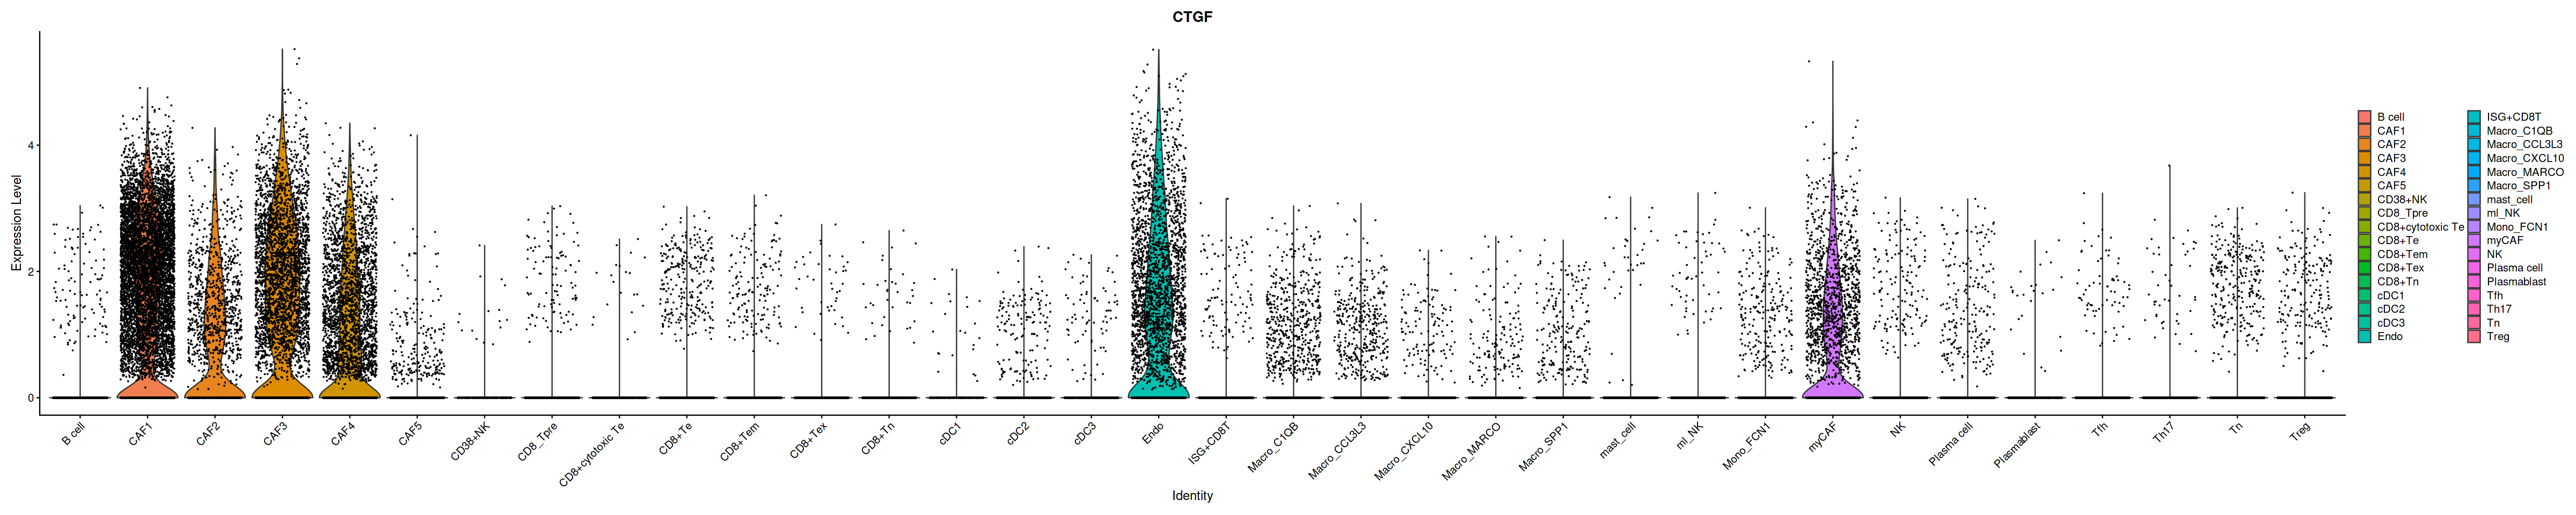

In [376]:
VlnPlot(object =mergeData_immune,features = 'CTGF',group.by = 'cellType' )

#### fisher精确检验识别细胞类型特异表达的基因

In [991]:
gene_fisher <- function(data=GSE183904_merge_224,Subcluster='Subcluster',assays='RNA',solt='counts',gene=node$name,cellTpye="Fibroblast",exp_cutoff=0){
            fibcell <- c(data@meta.data[,Subcluster] %in% cellTpye)
            n.cell <- ncol(data)
            dataExp <- GetAssayData(data,assay = assays,slot = solt)
            #gene <- intersect(gene,rownames(data))
            res.geneFisher <- lapply(gene,function(i){
                if(i=='CCN2'){
                    j='CTGF'
                }
                if(i=='CCN1'){
                    j='CYR61'
                }else{
                    j=i
                }
                if(j %in% rownames(data)){
                
                cell_expGene <- c(dataExp[j,]>exp_cutoff)
                a11 <- sum(fibcell * cell_expGene)
                a12 <- sum(cell_expGene)- a11
                a21 <- sum(fibcell)- a11
                a22 <- n.cell - a12 - a21 - a11
               fisher_matrix <- matrix(c(a11,
                              a12,
                              a21,
                              a22),
                              nrow=2)
                res <- fisher.test(fisher_matrix,alternative='greater')   
                
                res.data <- data.frame(gene=i,cellType=cellTpye,OR=0,P=0,P.adjust=0,number_of_cell_expGene=0,Proportion=0)
                res.data$OR[1] <- as.vector(res[[3]])
                res.data$P[1] <- as.vector(res[[1]])
                res.data$P.adjust[1] <- as.vector(res[[1]])
                res.data$number_of_cell_expGene[1] <- fisher_matrix[1]
                #fisher[i,'Proportion'] <- fisher_matrix[1]/(fisher_matrix[1]+fisher_matrix[2])  
                res.data$Proportion[1] <- fisher_matrix[1]/sum(fibcell)
                }else{
                   res.data <- data.frame(gene=i,cellType=cellTpye,OR=NA,P=NA,P.adjust=NA,number_of_cell_expGene=NA,Proportion=NA)     
                }
                return(res.data)
            })
    if(length(res.geneFisher)>1){
           res.geneFisher <- do.call(rbind,res.geneFisher)
           res.geneFisher$P.adjust <- p.adjust(res.geneFisher$P,n = length(res.geneFisher$P))
    }else{
       res.geneFisher <-  res.geneFisher[[1]]
    }

    return(res.geneFisher)
}


In [154]:
gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = geneboth[1:10],cellTpye = 'B cell')

gene   cellType OR         P P.adjust number_of_cell_expGene Proportion 
1  A2M    B cell   0.03888949 1 1         36                    0.010241821
2  A4GALT B cell   0.19983581 1 1         33                    0.009388336
3  AAK1   B cell   0.03149409 1 1         59                    0.016785206
4  AAMP   B cell   0.54212583 1 1        417                    0.118634424
5  ABCA1  B cell   0.14793425 1 1        106                    0.030156472
6  ABCA8  B cell   0.01391106 1 1          2                    0.000568990
7  ABCB1  B cell   0.52128107 1 1         86                    0.024466572
8  ABCC4  B cell   0.17469751 1 1         26                    0.007396871
9  ABCC9  B cell   0.00000000 1 1          0                    0.000000000
10 ABCF1  B cell   0.49202654 1 1        601                    0.170981508

In [821]:
s=Sys.time()
test <- gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = geneboth[1:10],cellTpye = 'B cell')

e=Sys.time()

print(e-s)


Time difference of 4.471301 secs


In [387]:
gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = 'CCN1',cellTpye = 'B cell')

gene cellType OR         P P.adjust number_of_cell_expGene Proportion
1 CCN1 B cell   0.08377849 1 1        86                     0.02065322

In [992]:
library(parallel)
cl <- makeCluster(8)

In [993]:
clusterExport(cl, varlist = c('gene_fisher','mergeData_immune','geneboth'))  # add other objects needed

In [994]:
clusterEvalQ(cl,{.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
    library('Seurat')})

[[1]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[2]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[3]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[4]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[5]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[6]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[7]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[8]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [995]:
gene_fisher_list <- parLapply(cl = cl,X = unique(mergeData_immune$cellType),fun = function(celltype){
    print(celltype)
    return(gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = geneboth,cellTpye = celltype))
})

In [996]:
names(gene_fisher_list) <- unique(mergeData_immune$cellType)

In [997]:
head(gene_fisher_list$`CD8+Tex`)

gene   cellType OR         P            P.adjust     number_of_cell_expGene
1 A2M    CD8+Tex  0.09024555 1.000000e+00 1.000000e+00   57                  
2 A4GALT CD8+Tex  0.01719840 1.000000e+00 1.000000e+00    2                  
3 AAED1  CD8+Tex  0.37678538 1.000000e+00 1.000000e+00  218                  
4 AAK1   CD8+Tex  1.62828276 3.828364e-32 1.740757e-28 1119                  
5 AAMDC  CD8+Tex  0.21486318 1.000000e+00 1.000000e+00   89                  
6 AAMP   CD8+Tex  0.60092075 1.000000e+00 1.000000e+00  318                  
  Proportion  
1 0.0231425091
2 0.0008120179
3 0.0885099472
4 0.4543239951
5 0.0361347950
6 0.1291108404

In [998]:
stopCluster(cl)

In [999]:
saveRDS(gene_fisher_list,file = './output/1.sangleCell_pre/OV_mergeData_immuneCell_geneFisher_list.RDS')

In [6]:
gene_fisher_list <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immuneCell_geneFisher_list.RDS')

In [7]:
names(gene_fisher_list)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

In [8]:
CIBERSORTx_immuneCell <- read.csv('/home/data/t060324/jobs/aimin/data/bulk/CIBERSORTx_mergeData.csv',header = T,sep = ',')
colnames(CIBERSORTx_immuneCell)

[1] "Mixture"                    "B.cell"                    
 [3] "CAF1"                       "CAF2"                      
 [5] "CAF3"                       "CAF4"                      
 [7] "CAF5"                       "CD38.NK"                   
 [9] "CD8.Te"                     "CD8.Tem"                   
[11] "CD8.Tex"                    "CD8.Tn"                    
[13] "CD8.TpreEx"                 "cDC1"                      
[15] "cDC2"                       "Endo"                      
[17] "ISG.CD8T"                   "Macro_C1QB"                
[19] "Macro_CCL3L3"               "Macro_CXCL10"              
[21] "Macro_MARCO"                "Macro_MT1H"                
[23] "Macro_SPP1"                 "mast_cell"                 
[25] "Mature.NK"                  "Mono_FCN1"                 
[27] "myCAF"                      "NK"                        
[29] "pDC"                        "Plasma.cell"               
[31] "Tfh"                        "Th17"                      
[33] "Tn"                         "Treg"                      
[35] "P.value"                    "Correlation"               
[37] "RMSE"                       "Absolute.score..sig.score."

### 识别细胞Abundance相关基因

In [9]:
## 以单细胞数据做参考，CIBERSORTx方法估算细胞浸润丰度
CIBERSORTx_immuneCell <- read.csv('/home/data/t060324/jobs/aimin/data/bulk/CIBERSORTx_mergeData2.csv',header = T,sep = ',')
rownames(CIBERSORTx_immuneCell) <- CIBERSORTx_immuneCell$Mixture
CIBERSORTx_immuneCell <- CIBERSORTx_immuneCell[,2:34]
colnames(CIBERSORTx_immuneCell) <- c('B cell','CAF1','CAF2','CAF3','CAF4','CAF5','CD38+NK','CD8+Te','CD8+Tem',
                                     'CD8+Tex','CD8+Tn','CD8+TpreEx','cDC1','cDC2','Endo','ISG+CD8T','Macro_C1QB','Macro_CCL3L3',
                                     'Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','mast_cell','Mature NK','Mono_FCN1','myCAF','NK','pDC',
                                     'Plasma cell','Tfh','Th17','Tn','Treg')
head(CIBERSORTx_immuneCell)

B cell      CAF1       CAF2       CAF3         CAF4      
TCGA.23.1120.01A 0.016018656 0.08196585 0.15443041 0.0000000000 0.02621643
TCGA.29.1695.01A 0.036235774 0.52022755 0.05702697 0.0000000000 0.00000000
TCGA.61.2003.01A 0.000000000 0.52167182 0.03186063 0.0000000000 0.12555359
TCGA.13.1404.01A 0.039672250 0.25104132 0.12369059 0.0372685402 0.00000000
TCGA.23.1027.01A 0.011086760 0.30488336 0.14419757 0.0004712983 0.00000000
TCGA.23.1022.01A 0.001259467 0.00000000 0.28058152 0.0000000000 0.00699572
                 CAF5         CD38+NK     CD8+Te     CD8+Tem     CD8+Tex ⋯
TCGA.23.1120.01A 0.0000000000 0.026965240 0.06287633 0.000000000 0       ⋯
TCGA.29.1695.01A 0.0000000000 0.000000000 0.12663414 0.000000000 0       ⋯
TCGA.61.2003.01A 0.0000000000 0.000000000 0.20801299 0.000000000 0       ⋯
TCGA.13.1404.01A 0.0000000000 0.022156710 0.10596354 0.001093635 0       ⋯
TCGA.23.1027.01A 0.0001075459 0.001361755 0.08530078 0.013454454 0       ⋯
TCGA.23.1022.01A 0.0000000000 0.000000000 0.05572791 0.008531318 0       ⋯
                 Mature NK  Mono_FCN1  myCAF      NK          pDC        
TCGA.23.1120.01A 0.00000000 0.00000000 0.02760410 0.002949724 0.035089009
TCGA.29.1695.01A 0.01313994 0.03261075 0.02354860 0.036000411 0.010470496
TCGA.61.2003.01A 0.00000000 0.02714180 0.04934227 0.024019638 0.008378977
TCGA.13.1404.01A 0.00000000 0.00000000 0.02461452 0.002962958 0.027181085
TCGA.23.1027.01A 0.00000000 0.00000000 0.00000000 0.003999559 0.012112269
TCGA.23.1022.01A 0.00000000 0.00000000 0.03371619 0.046173993 0.032643722
                 Plasma cell Tfh         Th17 Tn         Treg       
TCGA.23.1120.01A 0.00000000  0.009362166 0    0.07770413 0.000000000
TCGA.29.1695.01A 0.00000000  0.016881123 0    0.06517424 0.002506389
TCGA.61.2003.01A 0.00000000  0.000000000 0    0.09584818 0.019077341
TCGA.13.1404.01A 0.05232419  0.006046231 0    0.09397477 0.014542763
TCGA.23.1027.01A 0.00000000  0.010433680 0    0.08204756 0.008685669
TCGA.23.1022.01A 0.00000000  0.006834421 0    0.18028401 0.006606814

In [10]:
TCGA_exp <- TCGA_OV_TPM_log[geneboth,]

In [11]:
all(rownames(CIBERSORTx_immuneCell)==colnames(TCGA_exp))

[1] TRUE

##### 基因表达特异性评价
* OR>2 表示该基因在此细胞类型中有表达
* OR>3且在超过20%的细胞中有表达表示该基因可以作为此细胞类型的marker

In [158]:
gene_fisher_list <- lapply(gene_fisher_list,function(x){
    x$specificity <- ifelse(x$OR>2.5 | x$Proportion>0.3,'expressed','unexpressed')
    x$ismarker <- ifelse(x$Proportion>0.6 & x$OR>3,1,0)
    x <- subset(x,gene %in% geneboth)
    return(x)
})

In [159]:
sapply(gene_fisher_list,function(x){
    table(x$ismarker)
})


B cell pDC  Plasma cell Th17 NK   Tfh  CD8+Tem Tn   CD8+TpreEx CD8+Te ⋯
0 4811   4778 4877        4874 4866 4867 4870    4859 4865       4852   ⋯
1   73    106    7          10   18   17   14      25   19         32   ⋯
  Macro_CXCL10 Macro_MT1H Macro_MARCO CAF3 CAF1 CAF4 myCAF CAF2 CAF5 Endo
0 4661         4738       4589        4502 4629 3389 4635  4551 3411 4179
1  223          146        295         382  255 1495  249   333 1473  705

In [135]:
cellMarker <- sapply(gene_fisher_list,function(x){
   subset(x,ismarker==1)$gene
})


In [136]:
## 基于marker基因的zscore得分估算细胞丰度
library(GSVA)
cellTypeScore <- gsva(expr = TCGA_exp,gset.idx.list = cellMarker,method='ssgsea',kcdf="Gaussian")

Warning message in .filterFeatures(expr, method):
“1 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 33 gene sets.
  |======================================                                |  55%


In [19]:
cor(cellTypeScore['Plasma cell',],CIBERSORTx_immuneCell)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'cor': object 'cellTypeScore' not found


In [15]:
library(pheatmap)

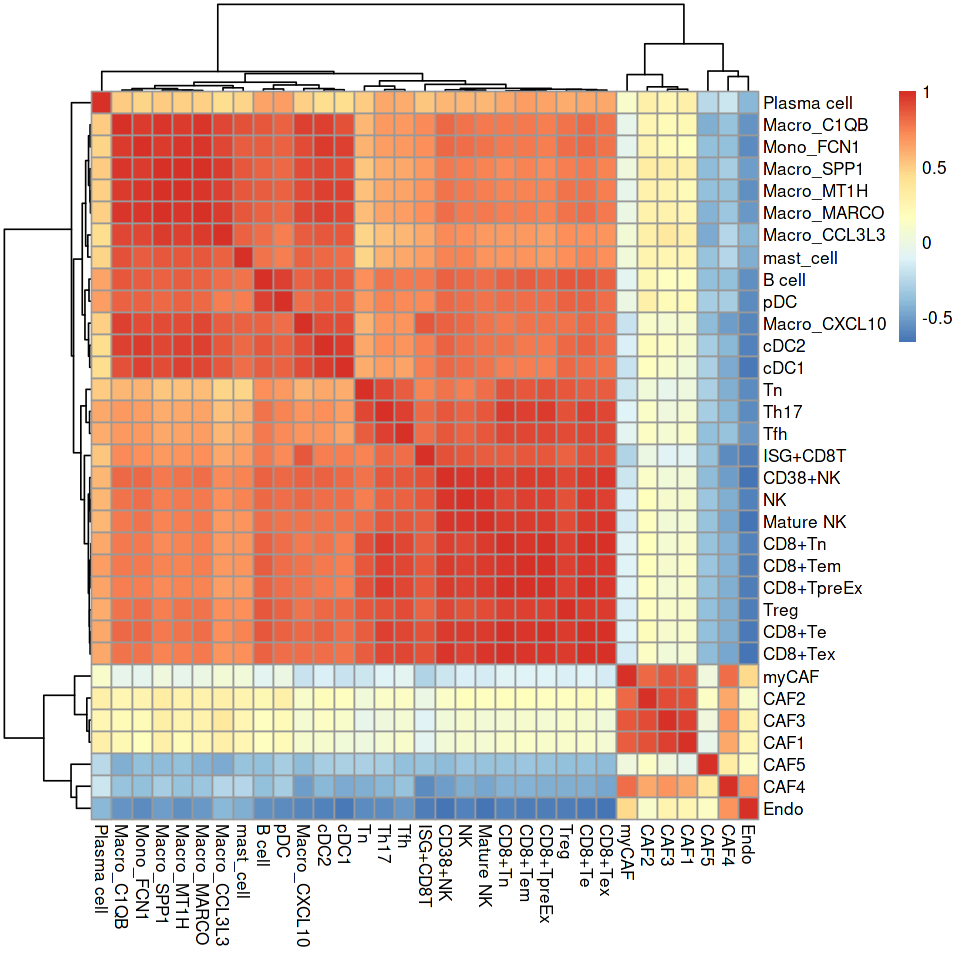

In [691]:
options(repr.plot.height =8, repr.plot.width = 8)
pheatmap(cor(t(cellTypeScore)))

In [692]:
cellTypeScore[1:6,1:6]

TCGA.23.1120.01A TCGA.29.1695.01A TCGA.61.2003.01A TCGA.13.1404.01A
B cell      0.36273313        0.33298717       0.34143072       0.36387289     
pDC         0.31093946        0.30790936       0.30806242       0.31975423     
Plasma cell 0.05531555        0.15851340       0.16013199       0.43961488     
Th17        0.14580502        0.08916725       0.09036683       0.07630216     
NK          0.04179579       -0.04218511      -0.03892714      -0.12174256     
Tfh         0.11310164        0.04223823       0.07538927       0.02572380     
            TCGA.23.1027.01A TCGA.23.1022.01A
B cell       0.309765832      0.236741658    
pDC          0.295002227      0.263102076    
Plasma cell -0.203850327      0.002216128    
Th17        -0.011525429     -0.022550612    
NK          -0.098741494     -0.189391324    
Tfh         -0.007032764     -0.085169219

In [693]:
CIBERSORTx_immuneCell[1:6,1:6]

B cell      CAF1      CAF2       CAF3        CAF4        CAF5
TCGA.23.1120.01A 0.019755845 0.1054106 0.10452044 0.000000000 0.019248146 0   
TCGA.29.1695.01A 0.024529571 0.5297088 0.05943348 0.003890111 0.000000000 0   
TCGA.61.2003.01A 0.000000000 0.5317506 0.02851435 0.000000000 0.119591566 0   
TCGA.13.1404.01A 0.030275454 0.2549425 0.12171711 0.040554397 0.000000000 0   
TCGA.23.1027.01A 0.008887944 0.3043251 0.14339054 0.010302609 0.000000000 0   
TCGA.23.1022.01A 0.000000000 0.0000000 0.29131656 0.000000000 0.008134925 0

最终选取CIBERSORTx方法构造的细胞丰度进行后续分析

In [137]:
gene2CellType <- cor(x = CIBERSORTx_immuneCell,y = t(TCGA_exp))
#gene2CellType <- cor(x = t(cellTypeScore),y = t(TCGA_exp))


Warning message in cor(x = CIBERSORTx_immuneCell, y = t(TCGA_exp)):
“the standard deviation is zero”


* 所有基因与细胞丰度计算spearman相关性
* 修正自表达基因的相关系数（在对应细胞类型中有表达的基因的cor修改为0）
* 排序修正后的相关性向量

In [138]:
names(gene_fisher_list)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

In [139]:
head(sort(gene2CellType['B cell',],decreasing = T),30)

IGHM      IRF4      LAX1     CD79A      CD27    SLAMF7       LY9     FCRL5 
0.6065358 0.5795836 0.5762040 0.5588997 0.5510217 0.5462429 0.5454020 0.5397940 
TNFRSF13B    P2RY10     ICAM3    JCHAIN    SLAMF1    SLAMF6      MZB1   POU2AF1 
0.5349463 0.5327570 0.5319895 0.5280731 0.5271315 0.5220490 0.5130850 0.5122504 
 TNFRSF17   SLFN12L   TMEM156  TRAF3IP3     MS4A1     SP140      IGKC     IGHG1 
0.5103187 0.5025891 0.5015388 0.5014123 0.4993792 0.4991474 0.4961473 0.4959800 
    IKZF3     IGHA1     IGHG2      RHOH      CD38      CCR7 
0.4922460 0.4915593 0.4908549 0.4849946 0.4826695 0.4805054

In [140]:
head(gene_fisher_list$`B cell`)

gene   cellType OR         P P.adjust number_of_cell_expGene Proportion 
1 A2M    B cell   0.03888949 1 1         36                    0.010241821
2 A4GALT B cell   0.19983581 1 1         33                    0.009388336
3 AAED1  B cell   0.67235779 1 1        517                    0.147083926
4 AAK1   B cell   0.03149409 1 1         59                    0.016785206
5 AAMDC  B cell   0.22177542 1 1        132                    0.037553343
6 AAMP   B cell   0.54212583 1 1        417                    0.118634424
  specificity ismarker
1 unexpressed 0       
2 unexpressed 0       
3 unexpressed 0       
4 unexpressed 0       
5 unexpressed 0       
6 unexpressed 0

In [168]:
subset(gene_fisher_list$Macro_SPP1,gene=='SERPINB8')

gene     cellType   OR       P            P.adjust    
3830 SERPINB8 Macro_SPP1 2.370416 4.776532e-55 1.774482e-51
     number_of_cell_expGene Proportion specificity ismarker
3830 494                    0.1667792  unexpressed 0

In [160]:
cellcorGene_list <- list()
for(cellType in names(gene_fisher_list)){
     print(cellType)
    cellcorGene_array <- gene2CellType[cellType,]
    geneExp_forCellType <- gene_fisher_list[[cellType]]
    expressedGene <- subset(geneExp_forCellType,specificity=='expressed')$gene
    cellcorGene_array[expressedGene] <- 0
    cellcorGene_list[[cellType]] <- sort(cellcorGene_array,decreasing = T)
}

[1] "B cell"
[1] "pDC"
[1] "Plasma cell"
[1] "Th17"
[1] "NK"
[1] "Tfh"
[1] "CD8+Tem"
[1] "Tn"
[1] "CD8+TpreEx"
[1] "CD8+Te"
[1] "CD8+Tex"
[1] "Treg"
[1] "Mature NK"
[1] "ISG+CD8T"
[1] "CD8+Tn"
[1] "CD38+NK"
[1] "cDC2"
[1] "Macro_C1QB"
[1] "Mono_FCN1"
[1] "Macro_CCL3L3"
[1] "mast_cell"
[1] "cDC1"
[1] "Macro_SPP1"
[1] "Macro_CXCL10"
[1] "Macro_MT1H"
[1] "Macro_MARCO"
[1] "CAF3"
[1] "CAF1"
[1] "CAF4"
[1] "myCAF"
[1] "CAF2"
[1] "CAF5"
[1] "Endo"


In [161]:
names(cellcorGene_list) <- names(gene_fisher_list)

* 提取top 20的基因用于构建细胞类型富集得分

In [162]:
Top20_list <- lapply(cellcorGene_list,function(x){
   x= x[which(x>0.25)]
    if(length(x)<20){
        return(names(x))
    }else{
        return(names(x[1:20]))
    }
    
})

In [163]:
cellcorGene_list$`CD8+Te`['CD27']

CD27 
0.5899738

In [164]:
saveRDS(Top20_list,file = './output/1.sangleCell_pre/Top20_list.RDS')

In [165]:
Top20_list <- readRDS(file = './output/1.sangleCell_pre/Top20_list.RDS')

In [166]:
Top20_list

$`B cell`
 [1] "LAX1"      "CD27"      "SLAMF7"    "SLAMF1"    "SLAMF6"    "MZB1"     
 [7] "SLFN12L"   "TRAF3IP3"  "SP140"     "IKZF3"     "CD38"      "ITGAL"    
[13] "IGHG3"     "IGHGP"     "ICOS"      "ITK"       "LINC00861" "CCR5"     
[19] "CD40LG"    "CXCR3"    

$pDC
 [1] "MLF1"     "AP3M2"    "ELAVL1"   "ANP32E"   "NAP1L4"   "TMEM189" 
 [7] "UBE2V2"   "CDKN2D"   "ATP5IF1"  "TECR"     "MSI2"     "TFG"     
[13] "ATP6V1H"  "SOX17"    "PHACTR4"  "C12orf65" "UBE2S"    "SSBP3"   
[19] "PBX4"     "CMSS1"   

$`Plasma cell`
 [1] "SLAMF1"     "ICAM3"      "CD27"       "LY9"        "SLAMF6"    
 [6] "TMEM156"    "RHOH"       "P2RY10"     "CXCL9"      "CXCL13"    
[11] "SH2D1A"     "SIT1"       "CXCR3"      "TRBC1"      "IKZF3"     
[16] "TRBC2"      "SIRPG"      "AC004585.1" "S1PR4"      "CXCR6"     

$Th17
 [1] "NR4A3"    "HAS1"     "ADAMTS4"  "GEM"      "HBEGF"    "PAPPA"   
 [7] "RGS2"     "C5AR1"    "SERPINE1" "MMP19"    "OSM"      "FOSL1"   
[13] "ADAM19"   "NR4A1"    "RUNX1T1"  "NLRP3"    "ERRFI1"   "DLC1"    
[19] "IL6"      "ITGA5"   

$NK
 [1] "IL16"   "ITK"    "RASAL3" "DOCK2"  "JAML"   "PRDM1"  "P2RY10" "LY9"   
 [9] "IL21R"  "RCSD1"  "GRAP2"  "ITGAL"  "ZEB2"   "THEMIS" "FLI1"   "CD84"  
[17] "NLRP3"  "MIAT"   "DOCK10" "TRAF1" 

$Tfh
 [1] "TNFRSF13B" "MS4A1"     "LY9"       "LINC00861" "P2RY10"    "SLAMF6"   
 [7] "SLAMF7"    "CCR7"      "SLFN12L"   "CXCL9"     "THEMIS"    "IRF4"     
[13] "EOMES"     "LAX1"      "CD8A"      "TMEM156"   "IL21R"     "FCRL5"    
[19] "TBX21"     "ZAP70"    

$`CD8+Tem`
character(0)

$Tn
 [1] "CCNB1IP1" "SNHG7"    "ATP5MC2"  "COLEC11"  "CFAP36"   "DPCD"    
 [7] "MYL6B"    "MORN2"    "ID4"      "FXYD1"    "UBXN8"    "IFT22"   
[13] "C12orf10" "SMIM26"   "TPPP3"    "EBPL"     "PITPNC1"  "SUPT3H"  
[19] "IMPDH2"   "ERGIC3"  

$`CD8+TpreEx`
 [1] "DCHS1"    "TIMP3"    "DLC1"     "PRKG1"    "FRMD6"    "VGLL3"   
 [7] "ADAMTS12" "HIC1"     "FBN1"     "SEPT11"   "SH3PXD2B" "PDGFRB"  
[13] "LAMB1"    "NUAK1"    "BMP2"     "NAV1"     "TCF4"     "LRP1"    
[19] "LSAMP"    "PTGIS"   

$`CD8+Te`
 [1] "SIRPG"   "KLRB1"   "SLAMF1"  "LST1"    "SH2D1A"  "CXCL9"   "NCR3"   
 [8] "SLAMF6"  "SLAMF7"  "LY9"     "CD27"    "NCF1"    "CCR5"    "TIGIT"  
[15] "TMEM156" "SPN"     "P2RY10"  "SLAMF8"  "S1PR4"   "TESPA1" 

$`CD8+Tex`
 [1] "TRGC1"      "LY9"        "AC004585.1" "CXCL9"      "P2RY10"    
 [6] "STAT4"      "IL21R"      "KLRB1"      "SLAMF7"     "TNFRSF13B" 
[11] "LINC00861"  "ZNF831"     "S1PR4"      "ANKRD22"    "LAX1"      
[16] "LINC00996"  "TMEM156"    "CD40LG"     "ARHGAP15"   "CD5"       

$Treg
 [1] "FCN1"     "NFKBIE"   "CLEC4E"   "BCL2A1"   "GNA15"    "MARCO"   
 [7] "TNF"      "SOD2"     "LST1"     "GPR84"    "NCF1"     "ADAM8"   
[13] "CD1E"     "CD68"     "CCL18"    "CD1C"     "SLC2A6"   "JAML"    
[19] "C15orf48" "NKG7"    

$`Mature NK`
 [1] "VGLL3"    "FAP"      "ADAM12"   "MMP19"    "ADAMTS2"  "ADAMTS12"
 [7] "PRKG1"    "FGF7"     "ITGBL1"   "IL16"     "ALDH1A3"  "FBN1"    
[13] "KCNE4"    "COL5A1"   "C1QTNF6"  "ANTXR2"   "NTM"      "SPARC"   
[19] "MMP2"     "ADAM19"  

$`ISG+CD8T`
 [1] "PARP12"   "ZNFX1"    "DTX3L"    "RABGAP1L" "ZCCHC2"   "SLC15A3" 
 [7] "LGALS3BP" "SP140L"   "APOBEC3A" "MYD88"    "TAP2"     "TRIM25"  
[13] "PRKD2"    "PML"      "UNC93B1"  "GBP3"     "OFD1"     "EFCAB14" 
[19] "UBE2H"    "ARHGAP26"

$`CD8+Tn`
 [1] "KLF4"    "NR4A3"   "DLC1"    "TGFBR1"  "GEM"     "TGFB3"   "LAMB1"  
 [8] "MYO1B"   "FSTL1"   "ERRFI1"  "DCHS1"   "RHOBTB3" "THBD"    "RAPH1"  
[15] "NR4A1"   "LATS2"   "B3GNT5"  "TSC22D2" "ARL5B"   "CHSY1"  

$`CD38+NK`
[1] "HERC6"  "IFIH1"  "IFI27"  "DDX60L"

$cDC2
 [1] "ZNF683"    "C2"        "APOL3"     "PSMB8-AS1" "CTSW"      "NCR3"     
 [7] "LINC01871" "CHI3L1"    "KLRB1"     "TMIGD2"    "XCL2"      "GZMA"     
[13] "TAP2"      "IL2RB"     "KLRC1"     "SELPLG"    "GNLY"      "CD247"    
[19] "CCL5"      "PIK3IP1"  

$Macro_C1QB
 [1] "GIMAP1"   "FLI1"     "BIN2"     "ARHGAP15" "SASH3"    "ARHGAP9" 
 [7] "GNG2"     "JAML"     "GIMAP6"   "SELPLG"   

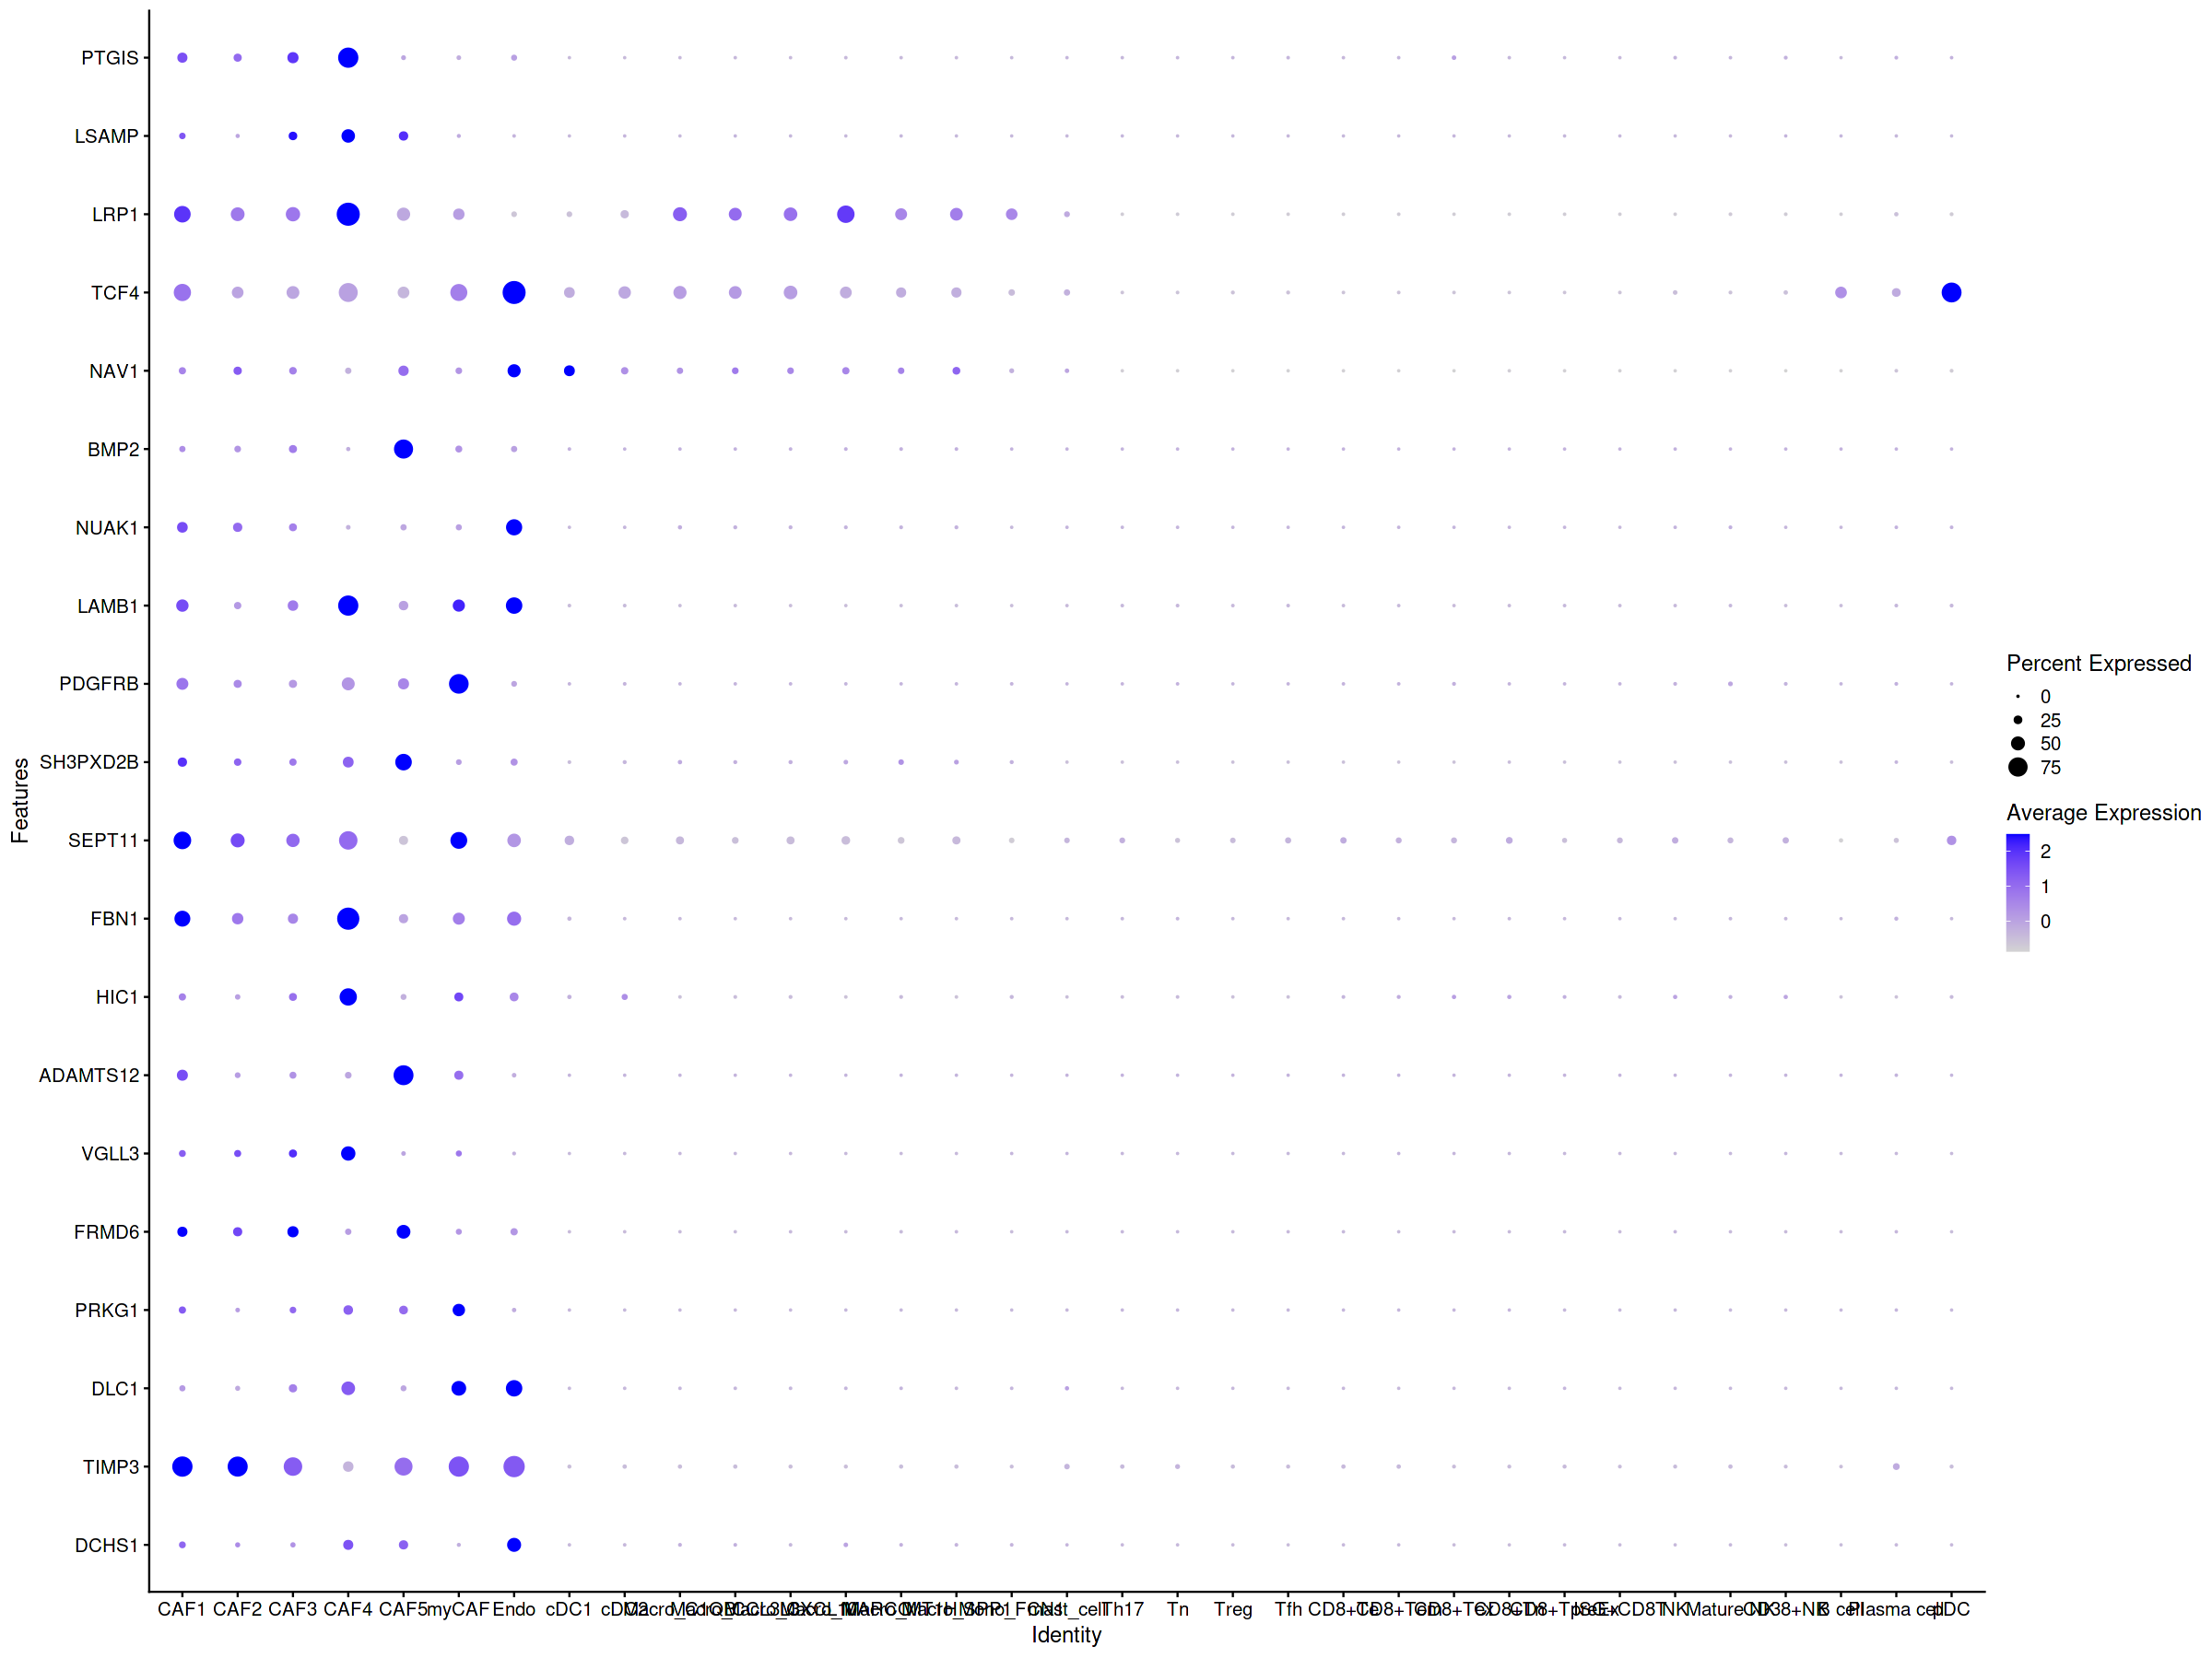

In [25]:
options(repr.plot.height = 15, repr.plot.width = 20)
DotPlot(object = mergeData_immune,features = Top20_list$`CD8+TpreEx`,group.by = 'cellType') + coord_flip()

##### 构造细胞类型富集得分
* 计算基因在每种细胞类型中的平均表达值并进行Zscore转化
* 对于某一细胞类型，提取与其高相关的Top 20基因
* 计算20个基因在每种细胞类型中的平均表达值作为富集得分（Escore）


In [169]:
Zscore_Top20 <- lapply(names(Top20_list),FUN = function(x){
    if(length(Top20_list[[x]])>0){
        test <- DotPlot(object = mergeData_immune,features = Top20_list[[x]],group.by = 'cellType')
        Zscore_data <- test$data
        Zscore_data$id <- as.character(Zscore_data$id)
        res <- sapply(X = unique(x = Zscore_data$id), FUN = function(y) {
            data.use <- Zscore_data[Zscore_data$id == 
                y, "avg.exp.scaled"]
                data.use <- mean(x = data.use)
            return(data.use)
        })
    }else{
        res <- rep(0,length(unique(mergeData_immune$cellType)))
        names(res) <- unique(mergeData_immune$cellType)
    }
    return(res)
})




In [170]:
names(Zscore_Top20) <- names(Top20_list)

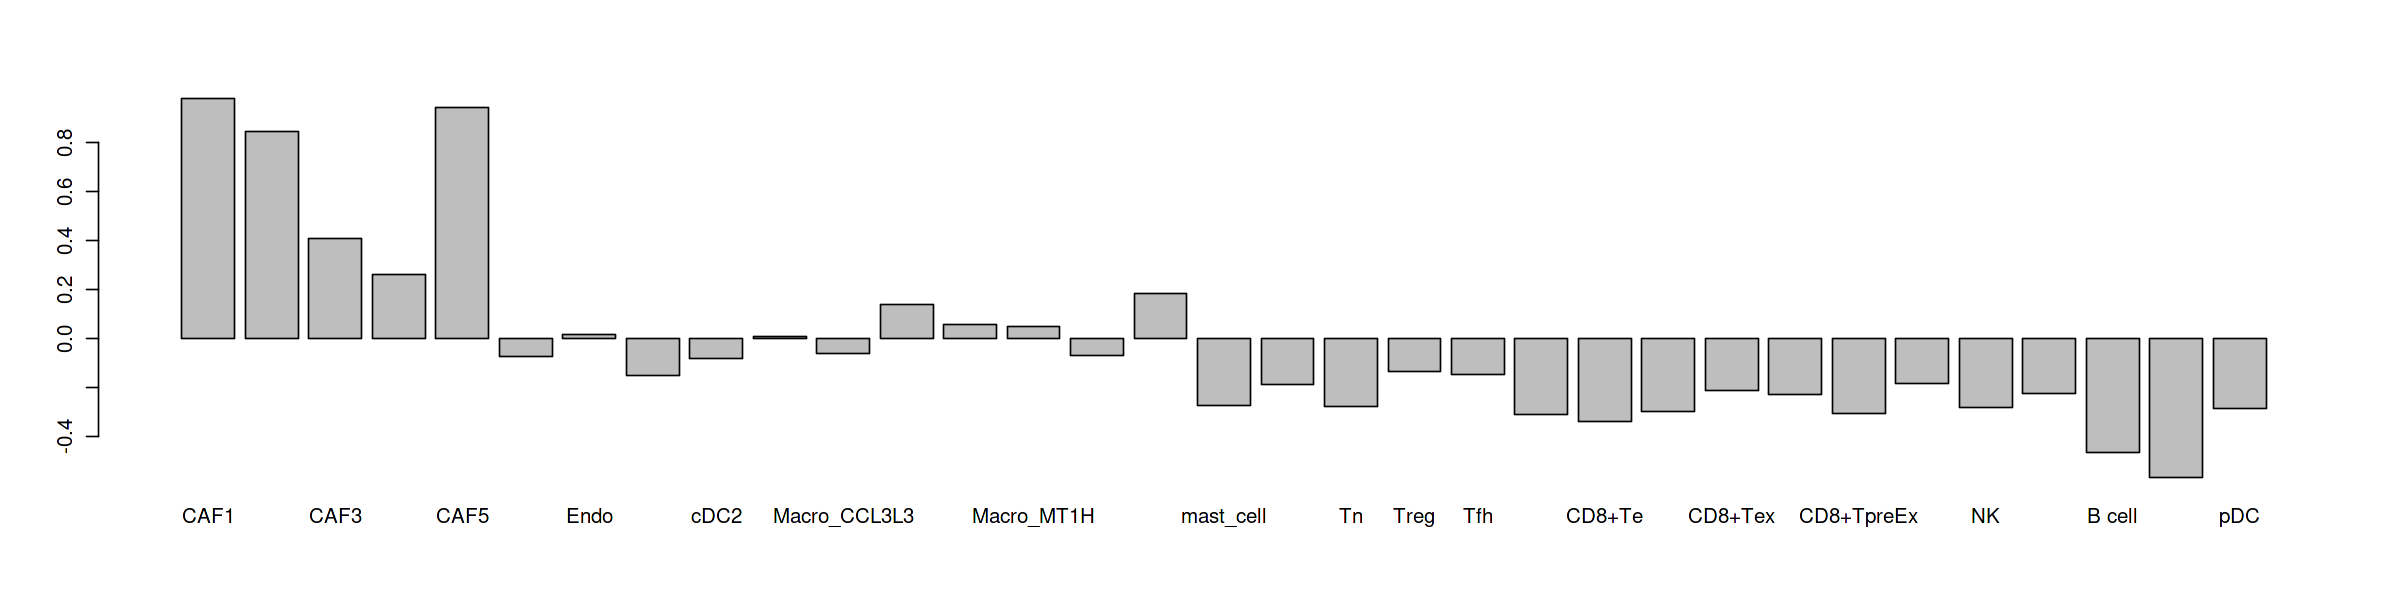

In [260]:
options(repr.plot.height = 5, repr.plot.width = 20)
barplot(height = Zscore_Top20$Macro_SPP1)

In [172]:
options(repr.plot.height = 10, repr.plot.width = 10)
pheatmap(do.call(cbind,Zscore_Top20))

ERROR: Error in pheatmap(do.call(cbind, Zscore_Top20)): could not find function "pheatmap"


##### 网络图绘制
* 提取Escore>0.7的细胞类型对作为潜在的cell-cell互作关系

In [261]:
x='Macro_SPP1'
Zscore_Top20[[x]]

CAF1         CAF2         CAF3         CAF4         CAF5        myCAF 
 0.980358893  0.843267860  0.409371812  0.261989528  0.945207289 -0.072082042 
        Endo         cDC1         cDC2   Macro_C1QB Macro_CCL3L3 Macro_CXCL10 
 0.016200815 -0.150324438 -0.079175559  0.008110046 -0.062669190  0.138238894 
 Macro_MARCO   Macro_MT1H   Macro_SPP1    Mono_FCN1    mast_cell         Th17 
 0.059523490  0.047654039 -0.070418946  0.182241987 -0.274717156 -0.185290773 
          Tn         Treg          Tfh      CD38+NK       CD8+Te      CD8+Tem 
-0.277896618 -0.132274468 -0.147921989 -0.310955432 -0.338807143 -0.297293768 
     CD8+Tex       CD8+Tn   CD8+TpreEx     ISG+CD8T           NK    Mature NK 
-0.210045989 -0.227560567 -0.306030441 -0.182888858 -0.279919252 -0.224341309 
      B cell  Plasma cell          pDC 
-0.466245536 -0.567265498 -0.287102513

In [287]:
cell2cell <- lapply(names(Zscore_Top20),function(x){
    res <- data.frame(sourceCell=x,targetCell=names(Zscore_Top20[[x]]),Escore=Zscore_Top20[[x]],edge=0)
    res$edge <- ifelse(res$Escore>1.1,1,0)
    return(res)
})
cell2cell <- do.call(rbind,cell2cell)

In [288]:
cell2cell_sub <- subset(cell2cell,edge==1)

In [289]:
names(Zscore_Top20)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

In [290]:
cellTypeMapping <- data.frame(lable=names(Zscore_Top20))
cellTypeMapping$Type <- cellTypeMapping$lable
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Th17','Tn','Treg','Tfh'),'CD4+ T',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T'),'CD8+ T',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('NK','Mature NK','CD38+NK'),'NK',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_SPP1','Mono_FCN1','Macro_MT1H','mast_cell','cDC1','cDC2'),'myeloid',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Plasma cell','B cell','pDC'),'B',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo'),'stroma cell',cellTypeMapping$Type)

In [291]:
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CD38+NK')
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CAF2')
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CAF5')


In [292]:
head(cell2cell_sub)

sourceCell  targetCell Escore   edge
CD8+Tex     B cell      CD8+Tex    1.255475 1   
ISG+CD8T    B cell      ISG+CD8T   1.236921 1   
Treg2       Plasma cell Treg       1.230033 1   
Tfh2        Plasma cell Tfh        1.221531 1   
CD8+Tex2    Plasma cell CD8+Tex    1.459040 1   
CD8+TpreEx2 Plasma cell CD8+TpreEx 1.106909 1

In [293]:
cellnames <- data.frame(label=c(cell2cell_sub$sourceCell,cell2cell_sub$targetCell) )
nodes<-cellnames%>%
    distinct()
nodes$Type <- NA

for(i in 1:nrow(nodes)){
    nodes[i,'Type']<-cellTypeMapping$Type[which(cellTypeMapping$lable==nodes$label[i])]
}

In [294]:
edges<-cell2cell_sub%>%
    rename(from=sourceCell,to=targetCell,weight=Escore)

In [295]:
edges <- subset(edges,from!=to)

In [296]:
edges

from         to           weight   edge
CD8+Tex        B cell       CD8+Tex      1.255475 1   
ISG+CD8T       B cell       ISG+CD8T     1.236921 1   
Treg2          Plasma cell  Treg         1.230033 1   
Tfh2           Plasma cell  Tfh          1.221531 1   
CD8+Tex2       Plasma cell  CD8+Tex      1.459040 1   
CD8+TpreEx2    Plasma cell  CD8+TpreEx   1.106909 1   
CD8+Tex4       NK           CD8+Tex      1.152101 1   
CAF47          Tn           CAF4         1.101472 1   
myCAF7         Tn           myCAF        1.282488 1   
CAF18          CD8+TpreEx   CAF1         1.444948 1   
CAF48          CD8+TpreEx   CAF4         1.151966 1   
Macro_MARCO11  Treg         Macro_MARCO  1.127314 1   
Macro_MT1H11   Treg         Macro_MT1H   1.164705 1   
Mono_FCN111    Treg         Mono_FCN1    1.102253 1   
CAF112         Mature NK    CAF1         1.650565 1   
CAF312         Mature NK    CAF3         1.192508 1   
Macro_CXCL1013 ISG+CD8T     Macro_CXCL10 1.459909 1   
CAF414         CD8+Tn       CAF4         1.153013 1   
CD38+NK16      cDC2         CD38+NK      1.677300 1   
NK16           cDC2         NK           1.530425 1   
CD8+Tex17      Macro_C1QB   CD8+Tex      1.353102 1   
CD8+TpreEx17   Macro_C1QB   CD8+TpreEx   1.123814 1   
ISG+CD8T17     Macro_C1QB   ISG+CD8T     1.328374 1   
Mature NK17    Macro_C1QB   Mature NK    1.370298 1   
CD8+Tex23      Macro_CXCL10 CD8+Tex      1.781063 1   
CD8+Tex25      Macro_MARCO  CD8+Tex      1.395743 1   
Endo28         CAF4         Endo         2.136425 1   
Endo29         myCAF        Endo         1.410488 1   
CAF432         Endo         CAF4         1.328987 1

In [297]:
net_pc

IGRAPH 484c810 UNW- 29 58 -- 
+ attr: name (v/c), Type (v/c), color (v/c), weight (e/n), edge (e/n),
| width (e/n)
+ edges from 484c810 (vertex names):
 [1] B cell     --CD8+Tex      B cell     --ISG+CD8T    
 [3] Plasma cell--Treg         Plasma cell--Tfh         
 [5] Plasma cell--CD8+Tex      Plasma cell--CD8+TpreEx  
 [7] Plasma cell--ISG+CD8T     Th17       --CAF3        
 [9] NK         --CD8+Tex      Tn         --CAF1        
[11] Tn         --CAF2         Tn         --CAF4        
[13] Tn         --myCAF        CD8+TpreEx --CAF1        
+ ... omitted several edges

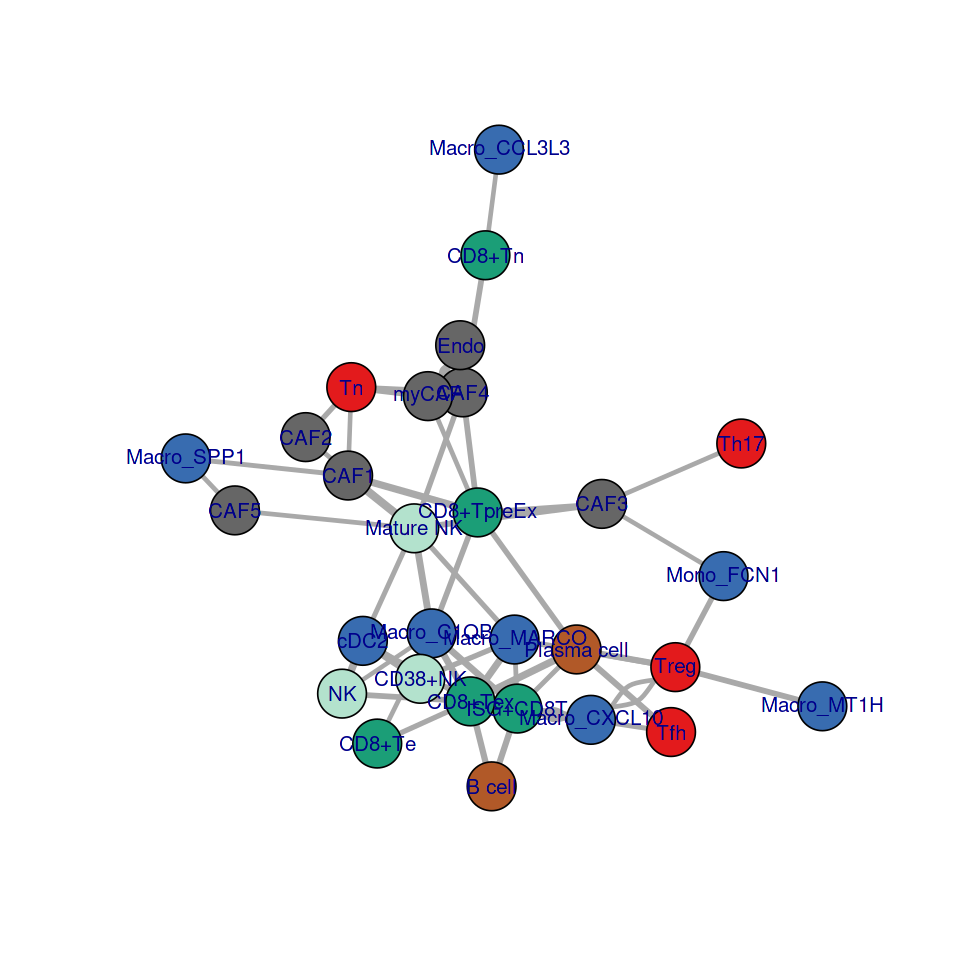

In [298]:
plot(net_pc)

In [299]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col2 <- sample(col_vector,6)

In [300]:
library(igraph)
net_pc<-graph_from_data_frame(
   d=edges,vertices=nodes,
   directed=F)
deg<-degree(net_pc,mode="all")
E(net_pc)$width<-E(net_pc)$weight*3
###设置颜色
vcolor<-cellType_col2
###指定节点的颜色
V(net_pc)$color<-vcolor[factor(V(net_pc)$Type)]

options(repr.plot.height = 10, repr.plot.width = 10)
set.seed(12345)
l <- layout_with_lgl(net_pc)
pdf(file = './output/bulk/section_4/1.cell2cellInteractions_network.pdf',width = 8,height =8)
plot(net_pc,vertex.size=2*deg,
vertex.label.cex=.7,vertex.label.dist=1,layout=l,
edge.color="gray50",edge.arrow.size=.4, edge.curved=.1)
###添加图例
legend(x=-1.3,y=1.2,levels(factor(V(net_pc)$Type)),pch=21,col="#777777",pt.bg=vcolor,border = F)
dev.off()

png 
  2

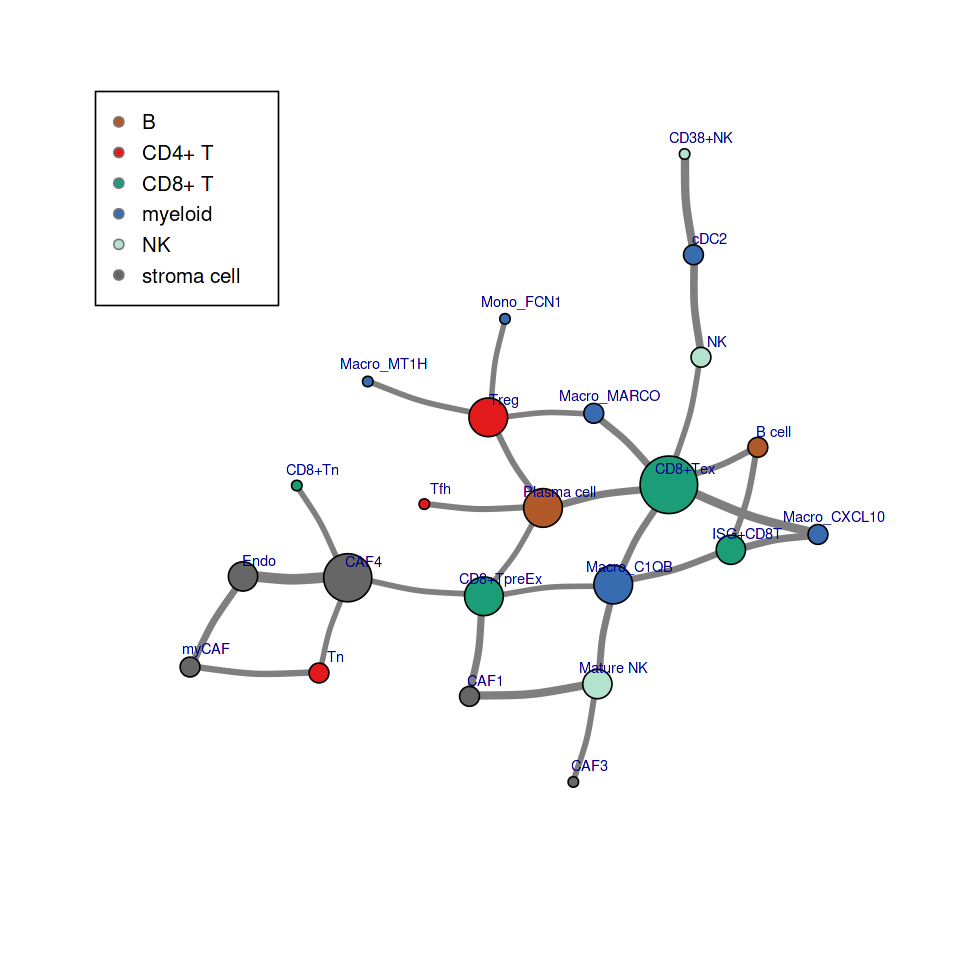

In [301]:
options(repr.plot.height = 8, repr.plot.width = 8)
set.seed(12345)
l <- layout_with_lgl(net_pc)
plot(net_pc,vertex.size=3*deg,
vertex.label.cex=.7,vertex.label.dist=1,layout=l,
edge.color="gray50",edge.arrow.size=.4, edge.curved=.1)
###添加图例
legend(x=-1.3,y=1.2,levels(factor(V(net_pc)$Type)),pch=21,col="#777777",pt.bg=vcolor,border = F)

In [241]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 5)

In [242]:
cellType_col

[1] "#B15928" "#E31A1C" "#1B9E77" "#386CB0" "#B3E2CD"

In [243]:
names(Top20_list)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

In [244]:
library(ggpubr)

In [245]:
selectCellType <- c('B cell','Plasma cell','Tfh','CD8+Te','CD8+Tex','ISG+CD8T','Macro_C1QB','Macro_CXCL10','Macro_MARCO','Macro_SPP1','CAF4')

In [246]:
library(aplot)
library(ggpubr)

In [302]:
pdf(file = paste0('./output/bulk/section_4/1.corGeneRankCellType.pdf'),width = 8,height =6)
for(x in selectCellType){
gene2CellTypeCor <- gene2CellType[x,Top20_list[[x]]]
gene2CellTypeCor <- data.frame(gene=names(gene2CellTypeCor),cor=gene2CellTypeCor)
cor_p <- ggplot(gene2CellTypeCor,aes(gene,cor))+ 
xlab(NULL) + ylab(label = 'PCC')+ geom_hline(yintercept = 0.5,size=.5,linetype = 2)+
geom_bar(stat="identity",position="identity",width = 0.6)+scale_y_continuous(position = "right",limits = c(0,1))+
ggtitle("")+ theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),axis.ticks.y = element_blank(),axis.text.y = element_blank())+
guides(fill=guide_legend(title=NULL)) + coord_flip()

cell_EScore <- data.frame(cellType=names(Zscore_Top20[[x]]),Escore=Zscore_Top20[[x]])
cell_EScore$cellType <- as.factor(cell_EScore$cellType)
cell_EScore$cellType <- factor(x = cell_EScore$cellType,
                               levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC'),
                                labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') 
                              )
options(repr.plot.height = 5, repr.plot.width = 20)
p1 <- ggbarplot(data = cell_EScore,x = 'cellType',y = 'Escore',fill = 'cellType',legend='None')+
xlab(NULL)+ylim(-1.5,2.1)+ggtitle(paste0('Genes associated with ',x))+geom_hline(yintercept = 1.1, linetype = 2)+
theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),legend.position="none",axis.ticks.x = element_blank(),axis.text.x = element_blank())
options(repr.plot.height = 10, repr.plot.width = 8)
test5 <- DotPlot(object = mergeData_immune,assay = 'RNA',
        features = Top20_list[[x]],cols = c('blue','red'),group.by = 'cellType')
marker_data  <- test5$data
marker_data$Zscore <- marker_data$avg.exp.scaled
marker_data$cluster <-  marker_data$id
marker_data$cluster <- factor(x = marker_data$cluster,
                               levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC'),
                                labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') 
                              )
group <- c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') %>% as.data.frame() %>% 
  mutate(group=c(rep("stroma cell",7),rep("myeloid cell",10),rep("NK cell",3),rep("CD4+ T cell",4),rep("CD8+ T cell",6),rep("B cell",3))) %>%
  mutate(p="Cell group") %>%
  ggplot(aes(.,y=p,fill=group))+scale_fill_manual("group", values =  cellType_col2)+
  geom_tile() + 
  scale_y_discrete(position="right") +
  theme_minimal()+xlab(NULL) + ylab(NULL) +
  theme(axis.text.x = element_blank())+
  labs(fill = "Cell group")

options(repr.plot.height = 6, repr.plot.width = 8)
p2 <- ggplot(marker_data, aes(y=features.plot, x=cluster, fill=Zscore))+ 
geom_raster()+scale_fill_gradient2(low="#003366", high="#990033", mid="white")+
theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5),axis.ticks.y = element_blank())+
xlab(NULL) + ylab(NULL)+
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))+
  geom_vline(xintercept=c(0.5,7.5,17.5,20.5,24.5,30.5,33.5),size=.8)
p3 <- p2 %>% 
insert_top(group, height = .05) %>% 
insert_top(p1, height = .35) %>%insert_right(cor_p,width = .4) 
print(p3)
}
dev.off()

Warning message:
“Removed 1 rows containing missing values (position_stack).”


png 
  2

In [174]:
subset(gene_fisher_list[[x]],gene%in%c(Top20_list[[x]],'CD27'))

gene      cellType OR         P            P.adjust    
625  CCR5      B cell   0.10919437 1.000000e+00 1.000000e+00
651  CD27      B cell   1.60445931 4.733378e-28 2.214748e-24
664  CD38      B cell   0.30236948 1.000000e+00 1.000000e+00
670  CD40LG    B cell   0.01430918 1.000000e+00 1.000000e+00
675  CD5       B cell   0.03176372 1.000000e+00 1.000000e+00
1020 CXCR3     B cell   0.24108643 1.000000e+00 1.000000e+00
1907 ICOS      B cell   0.01793560 1.000000e+00 1.000000e+00
1969 IGHGP     B cell   0.18034933 1.000000e+00 1.000000e+00
2064 ITGAL     B cell   0.24662949 1.000000e+00 1.000000e+00
2076 ITK       B cell   0.02496731 1.000000e+00 1.000000e+00
2220 LAX1      B cell   0.95812814 7.186435e-01 1.000000e+00
2261 LINC00861 B cell   0.02442371 1.000000e+00 1.000000e+00
2644 MZB1      B cell   1.27351677 2.264124e-04 1.000000e+00
3864 SH2D1A    B cell   0.01171242 1.000000e+00 1.000000e+00
3898 SIT1      B cell   1.16342031 1.640704e-03 1.000000e+00
3907 SLAMF1    B cell   0.75860523 9.999775e-01 1.000000e+00
3908 SLAMF6    B cell   0.83806584 9.853232e-01 1.000000e+00
3909 SLAMF7    B cell   0.55892075 1.000000e+00 1.000000e+00
3978 SLFN12L   B cell   0.11496323 1.000000e+00 1.000000e+00
4308 TESPA1    B cell   0.35237069 1.000000e+00 1.000000e+00
4343 TIGIT     B cell   0.09027102 1.000000e+00 1.000000e+00
     number_of_cell_expGene Proportion  specificity ismarker
625   36                    0.010241821 unexpressed 0       
651  781                    0.222190612 expressed   0       
664   94                    0.026742532 unexpressed 0       
670    2                    0.000568990 unexpressed 0       
675   10                    0.002844950 unexpressed 0       
1020 195                    0.055476529 unexpressed 0       
1907   8                    0.002275960 unexpressed 0       
1969  36                    0.010241821 unexpressed 0       
2064 145                    0.041251778 unexpressed 0       
2076  11                    0.003129445 unexpressed 0       
2220 178                    0.050640114 unexpressed 0       
2261   6                    0.001706970 unexpressed 0       
2644 255                    0.072546230 unexpressed 0       
3864   6                    0.001706970 unexpressed 0       
3898 474                    0.134850640 unexpressed 0       
3907 218                    0.062019915 unexpressed 0       
3908 151                    0.042958748 unexpressed 0       
3909 213                    0.060597440 unexpressed 0       
3978  36                    0.010241821 unexpressed 0       
4308  64                    0.018207681 unexpressed 0       
4343  55                    0.015647226 unexpressed 0

In [129]:
Zscore_Top20[[x]]

B cell      CD8+Tem   CD8+TpreEx       CD8+Te    Mature NK      CD8+Tex 
 -0.41828558   0.06668392  -0.10069805  -0.07283883   0.08377836   0.24698445 
          Tn     ISG+CD8T       CD8+Tn      CD38+NK           NK         Th17 
 -0.50328570   0.73203608  -0.12989071   0.60508127   0.02061564  -0.23605856 
        Treg          Tfh    mast_cell         CAF2  Plasma cell   Macro_C1QB 
 -0.09177174   0.06447027  -0.24129633  -0.44747801  -0.85839357   0.16539037 
        CAF5         Endo         CAF1 Macro_CCL3L3   Macro_SPP1 Macro_CXCL10 
 -0.21561826   0.60299867  -0.23694919   0.31619691   0.08908217   1.09431978 
   Mono_FCN1         cDC2   Macro_MT1H         cDC1  Macro_MARCO         CAF3 
  0.16994778  -0.23634491  -0.10067730  -0.37145331   0.31572423  -0.31923793 
       myCAF         CAF4          pDC 
 -0.23276346  -0.47318265  -0.11524246

In [111]:
gene2CellTypeCor$gene <- factor(x = gene2CellTypeCor$gene,levels = gene2CellTypeCor$gene,labels = gene2CellTypeCor$gene)

In [116]:
head(gene2CellTypeCor)

gene       cor      
LY9        LY9        0.4830314
AC004585.1 AC004585.1 0.4487408
CXCL9      CXCL9      0.4092671
STAT4      STAT4      0.3960054
KLRB1      KLRB1      0.3891505
SLAMF7     SLAMF7     0.3867954

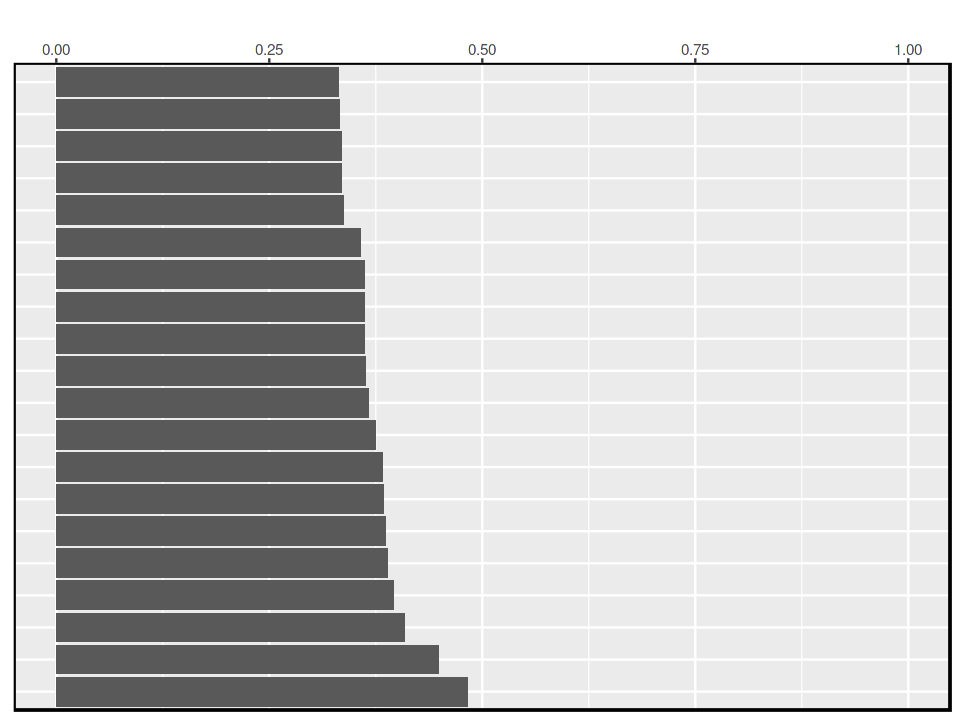

In [120]:
cor_p <- ggplot(gene2CellTypeCor,aes(gene,cor))+ 
xlab(NULL) + ylab(NULL)+ 
geom_bar(stat="identity",position="identity")+scale_y_continuous(position = "right",limits = c(0,1))+
ggtitle("")+ theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),axis.ticks.y = element_blank(),axis.text.y = element_blank())+
guides(fill=guide_legend(title=NULL)) + coord_flip()
cor_p

In [7]:
'IFNR' %in% rownames(mergeData_immune)[1:6]

[1] FALSE

In [9]:
rownames(mergeData_immune)[grep(pattern = 'IFN',x = rownames(mergeData_immune))]

[1] "IFNLR1"   "IFNGR1"   "IFNB1"    "IFNA22P"  "IFNA5"    "IFNA13"  
 [7] "IFNA2"    "IFNE"     "IFNK"     "IFNG-AS1" "IFNG"     "IFNL3"   
[13] "IFNL4"    "IFNL2"    "IFNL1"    "IFNAR2"   "IFNAR1"   "IFNGR2"  
[19] "IFNW1"    "IFNA21"   "IFNA4"    "IFNA7"    "IFNA10"   "IFNA16"  
[25] "IFNA17"   "IFNA14"   "IFNA6"    "IFNA8"    "IFNA1"

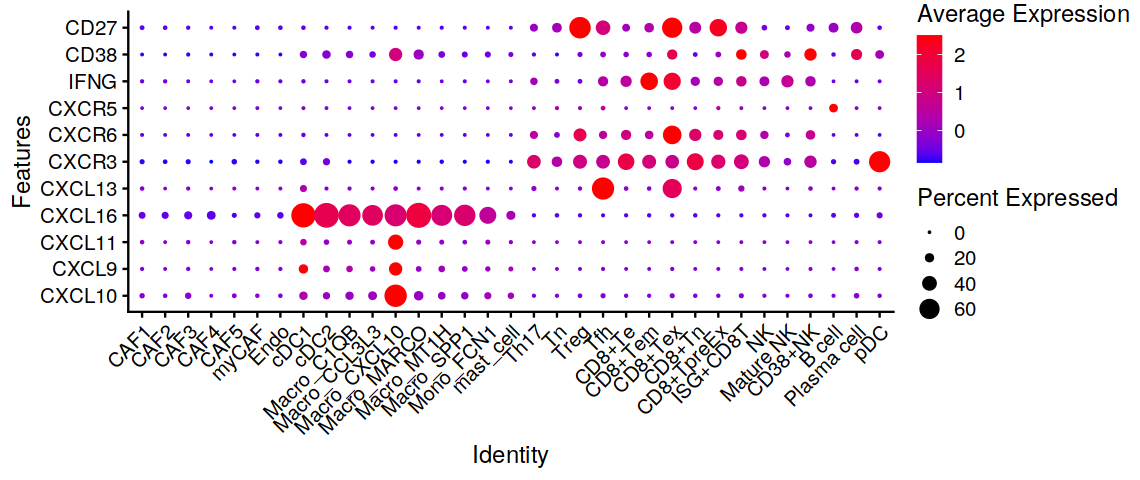

In [14]:
options(repr.plot.height = 4, repr.plot.width = 9.5)
p1 <- DotPlot(mergeData_immune,group.by = 'cellType',cols = c('blue','red'), features = c('CXCL10','CXCL9','CXCL11','CXCL16','CXCL13','CXCR3','CXCR6','CXCR5','IFNG','CD38','CD27'),assay = 'RNA',cluster.idents = F)+ coord_flip()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

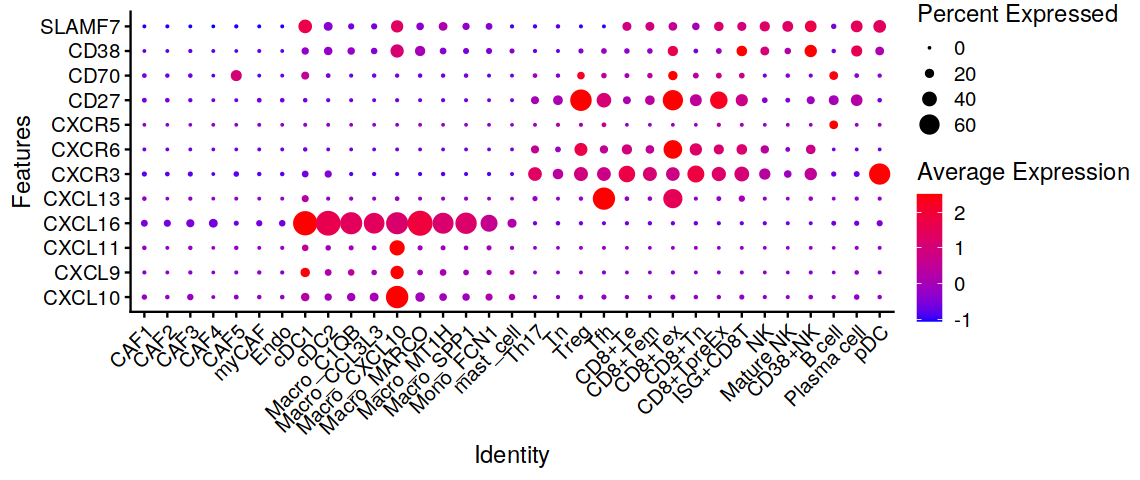

In [3]:
options(repr.plot.height = 4, repr.plot.width = 9.5)
p1 <- DotPlot(mergeData_immune,group.by = 'cellType',cols = c('blue','red'), features = c('CXCL10','CXCL9','CXCL11','CXCL16','CXCL13','CXCR3','CXCR6','CXCR5','CD27','CD70','CD38','SLAMF7'),assay = 'RNA',cluster.idents = F)+ coord_flip()+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

In [15]:
pdf(file = './output/bulk/section_4/3.immune_cell_selectgene_DotPlot.pdf',width = 9.5,height = 4)
print(p1)
dev.off()

png 
  2